In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [2]:
import os
print(os.getcwd())

/home/srp/research/Fairness/fairness_AL/codes


In [3]:
device = torch.device('cuda:0')

In [4]:
from utils.test_utils import obtain_AL_ckpts, split_AL_loaders
from utils.test_utils import load_AL_config, load_AL_dataloader, load_test_model, test_group_perf

In [47]:
save_dir = "../results/simulation/220417_2038"
config_file, state_list, data_files, arg_file = obtain_AL_ckpts(save_dir)

unknown file:  clf_logs.cls
unknown file:  clf_lr_logs.cls


In [48]:
print(state_list, data_files)

['binaryNN_0.pt', 'binaryNN_1.pt', 'binaryNN_10.pt', 'binaryNN_11.pt', 'binaryNN_12.pt', 'binaryNN_13.pt', 'binaryNN_14.pt', 'binaryNN_15.pt', 'binaryNN_16.pt', 'binaryNN_17.pt', 'binaryNN_18.pt', 'binaryNN_19.pt', 'binaryNN_2.pt', 'binaryNN_20.pt', 'binaryNN_21.pt', 'binaryNN_22.pt', 'binaryNN_23.pt', 'binaryNN_24.pt', 'binaryNN_25.pt', 'binaryNN_26.pt', 'binaryNN_27.pt', 'binaryNN_28.pt', 'binaryNN_29.pt', 'binaryNN_3.pt', 'binaryNN_30.pt', 'binaryNN_31.pt', 'binaryNN_32.pt', 'binaryNN_33.pt', 'binaryNN_34.pt', 'binaryNN_35.pt', 'binaryNN_36.pt', 'binaryNN_37.pt', 'binaryNN_38.pt', 'binaryNN_39.pt', 'binaryNN_4.pt', 'binaryNN_40.pt', 'binaryNN_41.pt', 'binaryNN_42.pt', 'binaryNN_43.pt', 'binaryNN_44.pt', 'binaryNN_45.pt', 'binaryNN_46.pt', 'binaryNN_47.pt', 'binaryNN_48.pt', 'binaryNN_49.pt', 'binaryNN_5.pt', 'binaryNN_50.pt', 'binaryNN_51.pt', 'binaryNN_52.pt', 'binaryNN_53.pt', 'binaryNN_54.pt', 'binaryNN_55.pt', 'binaryNN_56.pt', 'binaryNN_57.pt', 'binaryNN_58.pt', 'binaryNN_59.pt

### load models and train data loaders

In [49]:
args = load_AL_config(save_dir, config_file)
dl_loader = load_AL_dataloader(args.save_dir,'final_dataloader.pkl')
test_loader = load_AL_dataloader(args.save_dir,'test_loader.pkl')

In [50]:
dl_loaders,dl_cum_loaders = split_AL_loaders(dl_loader, args)

/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)


In [51]:
import pickle, os
with open(os.path.join(args.save_dir, 'selected_group_results.pkl'),'rb') as f:
    gids = pickle.load(f)

In [52]:
from utils.test_utils import test_groupwise, test_model

In [53]:
from sklearn.linear_model import LogisticRegression as LogR

In [54]:
def dic2logdic(log_gs, log_g, tag = 'train'):
    if len(log_gs[tag].keys())==0:
        for zi in log_g.keys():
            log_gs[tag][zi] = []
            
    for zi in log_g.keys():
        
        log_gs[tag][zi].append(log_g[zi])
    return log_gs

In [55]:
loss_gs = {}
acc_gs = {}
loss_log = {}
acc_log = {}

loss_gs['train'] = {}
loss_gs['test'] = {}
acc_gs['train'] = {}
acc_gs['test'] = {}

loss_log['train'] = []
loss_log['test'] = []
acc_log['train'] = []
acc_log['test'] = []

loss_log['train_w'] = []
loss_log['test_w'] = []
acc_log['train_w'] = []
acc_log['test_w'] = []

for it in range(len(state_list)):
    st = args.problem_type+args.model_type +"_"+ str(it)+ ".pt"
    print("="*50)
    clf,clf_criterion = load_test_model(save_dir, st, args)
    loss, acc = test_model(clf, dl_cum_loaders[it],clf_criterion, device, args.problem_type)
    acc_log['train'].append(acc.item())
    loss_log['train'].append(loss.item())
    
    loss, acc2 = test_model(clf, test_loader,clf_criterion, device, args.problem_type)
    acc_log['test'].append(acc2.item())
    loss_log['test'].append(loss.item())
    
    lrclf = LogR().fit(dl_cum_loaders[it].dataset.tensors[0].numpy(),dl_cum_loaders[it].dataset.tensors[1].numpy())
    acc3 = lrclf.score(dl_cum_loaders[it].dataset.tensors[0].numpy(),dl_cum_loaders[it].dataset.tensors[1].numpy())
    acc4 = lrclf.score(test_loader.dataset.tensors[0].numpy(),test_loader.dataset.tensors[1].numpy())
    print("cumulated total training/test acc:", acc,"/",acc2,"/",acc3*100,"/",acc4*100)
    loss_g, acc_g,loss_w, acc_w = test_group_perf(clf, dl_cum_loaders[it],clf_criterion, device, 
               AL_select = args.AL_select, problem_type = args.problem_type, return_loader=False)
    loss_gs = dic2logdic(loss_gs, loss_g, tag = 'train')
    acc_gs = dic2logdic(acc_gs, acc_g, tag = 'train')
    loss_log['train_w'].append(loss_w)
    acc_log['train_w'].append(acc_w)
    
    print("test set performance")
    loss_g, acc_g, loss_w, acc_w = test_group_perf(clf, test_loader,clf_criterion, device, 
               AL_select = args.AL_select, problem_type = args.problem_type, return_loader=False)
    loss_gs = dic2logdic(loss_gs, loss_g, tag = 'test')
    acc_gs = dic2logdic(acc_gs, acc_g, tag = 'test')
    loss_log['test_w'].append(loss_w)
    acc_log['test_w'].append(acc_w)
    
    print("selected group is", gids[it])
    print('-'*50)
    for i in range(it+1):
        _, acc = test_model(clf, dl_loaders[i],clf_criterion, device, args.problem_type)
        print("data loader",i, "acc:",acc)
        test_groupwise(clf, dl_loaders[i],clf_criterion, device, 
               AL_select = args.AL_select, problem_type = args.problem_type, return_loader=False)
        print("")

loaded model is binaryNN_0.pt
cumulated total training/test acc: tensor(81.) / tensor(62.0690) / 96.0 / 70.3923900118906
0.0 : loss 0.46421754360198975 / acc 80.0
1.0 : loss 0.4112711250782013 / acc 83.33332824707031
test set performance
0.0 : loss 0.6492812037467957 / acc 62.41721725463867
1.0 : loss 0.6773543953895569 / acc 61.181434631347656
selected group is 0.0
--------------------------------------------------
data loader 0 acc: tensor(81.)
0.0 : loss 0.46421754360198975 / acc 80.0
1.0 : loss 0.4112711250782013 / acc 83.33332824707031

loaded model is binaryNN_1.pt
cumulated total training/test acc: tensor(86.3636) / tensor(65.5172) / 95.45454545454545 / 73.24613555291319
0.0 : loss 0.445747435092926 / acc 88.42105102539062
1.0 : loss 0.4922206997871399 / acc 81.0810775756836
test set performance
0.0 : loss 0.628506600856781 / acc 66.39073181152344
1.0 : loss 0.6550695300102234 / acc 63.2911376953125
selected group is 1.0
--------------------------------------------------
data lo

/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)
/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/u

cumulated total training/test acc: tensor(89.0244) / tensor(63.6147) / 95.73170731707317 / 73.84066587395958
0.0 : loss 0.30683425068855286 / acc 88.33333587646484
1.0 : loss 0.29665490984916687 / acc 90.90908813476562
test set performance
0.0 : loss 0.7099683880805969 / acc 65.39735412597656
1.0 : loss 0.8505232930183411 / acc 59.07173156738281
selected group is 0.0
--------------------------------------------------
data loader 0 acc: tensor(84.)
0.0 : loss 0.36829641461372375 / acc 81.42857360839844
1.0 : loss 0.33551743626594543 / acc 90.0

data loader 1 acc: tensor(93.7500)
0.0 : loss 0.24104849994182587 / acc 96.0
1.0 : loss 0.26291367411613464 / acc 85.71428680419922

data loader 2 acc: tensor(100.)
0.0 : loss 0.20052571594715118 / acc 100.0
1.0 : loss 0.16384267807006836 / acc 100.0

loaded model is binaryNN_3.pt
cumulated total training/test acc: tensor(86.7347) / tensor(64.3282) / 95.91836734693877 / 75.50535077288941
0.0 : loss 0.3199581503868103 / acc 86.71328735351562
1.0 :

/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)
/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/u

cumulated total training/test acc: tensor(90.3509) / tensor(67.5386) / 93.85964912280701 / 76.33769322235435
0.0 : loss 0.2919960021972656 / acc 90.41915893554688
1.0 : loss 0.3550427556037903 / acc 90.16393280029297
test set performance
0.0 : loss 0.7796393632888794 / acc 68.37748718261719
1.0 : loss 0.903266191482544 / acc 65.40084075927734
selected group is 0.0
--------------------------------------------------
data loader 0 acc: tensor(87.)
0.0 : loss 0.38967591524124146 / acc 87.14286041259766
1.0 : loss 0.5335149168968201 / acc 86.66666412353516

data loader 1 acc: tensor(96.8750)
0.0 : loss 0.1501362919807434 / acc 96.0
1.0 : loss 0.07271245867013931 / acc 100.0

data loader 2 acc: tensor(93.7500)
0.0 : loss 0.23191283643245697 / acc 92.0
1.0 : loss 0.0992126613855362 / acc 100.0

data loader 3 acc: tensor(93.7500)
0.0 : loss 0.1424015909433365 / acc 95.65217590332031
1.0 : loss 0.22155912220478058 / acc 88.88888549804688

data loader 4 acc: tensor(87.5000)
0.0 : loss 0.36081451

/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)
/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/u

cumulated total training/test acc: tensor(86.6438) / tensor(68.4899) / 93.4931506849315 / 78.83472057074911
0.0 : loss 0.29057812690734863 / acc 88.67924499511719
1.0 : loss 0.5024051070213318 / acc 81.25
test set performance
0.0 : loss 0.6901152729988098 / acc 69.37085723876953
1.0 : loss 0.7873085141181946 / acc 66.2447280883789
selected group is 0.0
--------------------------------------------------
data loader 0 acc: tensor(80.)
0.0 : loss 0.3234063386917114 / acc 84.28571319580078
1.0 : loss 0.7783514857292175 / acc 70.0

data loader 1 acc: tensor(96.8750)
0.0 : loss 0.20180363953113556 / acc 96.0
1.0 : loss 0.1261109560728073 / acc 100.0

data loader 2 acc: tensor(87.5000)
0.0 : loss 0.28517282009124756 / acc 84.0
1.0 : loss 0.290058970451355 / acc 100.0

data loader 3 acc: tensor(90.6250)
0.0 : loss 0.19815737009048462 / acc 91.3043441772461
1.0 : loss 0.29663699865341187 / acc 88.88888549804688

data loader 4 acc: tensor(90.6250)
0.0 : loss 0.28652650117874146 / acc 91.66666412

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)
/home/srp/.pyenv/versions/pytorch15/lib/python3

0.0 : loss 0.7073697447776794 / acc 72.68212127685547
1.0 : loss 0.9191514849662781 / acc 66.2447280883789
selected group is 0.0
--------------------------------------------------
data loader 0 acc: tensor(81.)
0.0 : loss 0.3231794536113739 / acc 84.28571319580078
1.0 : loss 0.6423633694648743 / acc 73.33332824707031

data loader 1 acc: tensor(96.8750)
0.0 : loss 0.18168826401233673 / acc 96.0
1.0 : loss 0.12845644354820251 / acc 100.0

data loader 2 acc: tensor(93.7500)
0.0 : loss 0.1615818589925766 / acc 96.0
1.0 : loss 0.46359285712242126 / acc 85.71428680419922

data loader 3 acc: tensor(81.2500)
0.0 : loss 0.23156137764453888 / acc 86.9565200805664
1.0 : loss 0.5222454071044922 / acc 66.66666412353516

data loader 4 acc: tensor(87.5000)
0.0 : loss 0.24898402392864227 / acc 91.66666412353516
1.0 : loss 0.4545271396636963 / acc 75.0

data loader 5 acc: tensor(78.1250)
0.0 : loss 0.32451963424682617 / acc 82.60869598388672
1.0 : loss 0.4415060579776764 / acc 66.66666412353516

data l

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)
/home/srp/.pyenv/versions/pytorch15/lib/python3

1.0 : loss 0.5917825102806091 / acc 83.33332824707031

data loader 8 acc: tensor(81.2500)
0.0 : loss 0.47308671474456787 / acc 77.2727279663086
1.0 : loss 0.367082417011261 / acc 90.0

data loader 9 acc: tensor(93.7500)
0.0 : loss 0.3532272279262543 / acc 89.47368621826172
1.0 : loss 0.28850507736206055 / acc 100.0

data loader 10 acc: tensor(84.3750)
0.0 : loss 0.5259453058242798 / acc 77.2727279663086
1.0 : loss 0.34287968277931213 / acc 100.0

loaded model is binaryNN_11.pt
cumulated total training/test acc: tensor(79.4248) / tensor(73.0083) / 92.92035398230088 / 84.42330558858502
0.0 : loss 0.4090302288532257 / acc 78.22085571289062
1.0 : loss 0.4757988154888153 / acc 82.53968048095703
test set performance
0.0 : loss 0.6985264420509338 / acc 74.17218780517578
1.0 : loss 0.8672633767127991 / acc 70.04219055175781
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(76.)
0.0 : loss 0.4584330916404724 / acc 78.57142639160156
1.0 : loss 0.7

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)
/home/srp/.pyenv/versions/pytorch15/lib/python3

cumulated total training/test acc: tensor(77.4793) / tensor(72.6516) / 92.56198347107438 / 85.25564803804994
0.0 : loss 0.49519678950309753 / acc 77.6836166381836
1.0 : loss 0.5435269474983215 / acc 76.92308044433594
test set performance
0.0 : loss 0.520154595375061 / acc 74.00662231445312
1.0 : loss 0.6118178963661194 / acc 69.19831085205078
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(74.)
0.0 : loss 0.4917357861995697 / acc 77.14286041259766
1.0 : loss 0.6795433163642883 / acc 66.66666412353516

data loader 1 acc: tensor(81.2500)
0.0 : loss 0.4149262607097626 / acc 80.0
1.0 : loss 0.35584455728530884 / acc 85.71428680419922

data loader 2 acc: tensor(81.2500)
0.0 : loss 0.39704859256744385 / acc 84.0
1.0 : loss 0.47001340985298157 / acc 71.42857360839844

data loader 3 acc: tensor(84.3750)
0.0 : loss 0.4395695626735687 / acc 86.9565200805664
1.0 : loss 0.6777139902114868 / acc 77.77777099609375

data loader 4 acc: tensor(78.1250)

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)
/home/srp/.pyenv/versions/pytorch15/lib/python3

1.0 : loss 0.38415542244911194 / acc 85.71428680419922

data loader 3 acc: tensor(84.3750)
0.0 : loss 0.2653295397758484 / acc 86.9565200805664
1.0 : loss 0.5922518372535706 / acc 77.77777099609375

data loader 4 acc: tensor(81.2500)
0.0 : loss 0.4035392701625824 / acc 79.16666412353516
1.0 : loss 0.3404339551925659 / acc 87.5

data loader 5 acc: tensor(65.6250)
0.0 : loss 0.5537163615226746 / acc 65.21739196777344
1.0 : loss 0.6163437366485596 / acc 66.66666412353516

data loader 6 acc: tensor(84.3750)
0.0 : loss 0.31328439712524414 / acc 90.90908813476562
1.0 : loss 0.4829173982143402 / acc 70.0

data loader 7 acc: tensor(87.5000)
0.0 : loss 0.2994941771030426 / acc 88.46153259277344
1.0 : loss 0.6536763906478882 / acc 83.33332824707031

data loader 8 acc: tensor(93.7500)
0.0 : loss 0.2984083890914917 / acc 95.45454406738281
1.0 : loss 0.28107187151908875 / acc 90.0

data loader 9 acc: tensor(81.2500)
0.0 : loss 0.30647012591362 / acc 89.47368621826172
1.0 : loss 0.4175627529621124 /

/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)
/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/u

0.0 : loss 0.22188323736190796 / acc 95.65217590332031
1.0 : loss 0.5304072499275208 / acc 77.77777099609375

data loader 4 acc: tensor(81.2500)
0.0 : loss 0.39707884192466736 / acc 79.16666412353516
1.0 : loss 0.3444159924983978 / acc 87.5

data loader 5 acc: tensor(78.1250)
0.0 : loss 0.4122704267501831 / acc 73.91304016113281
1.0 : loss 0.38238584995269775 / acc 88.88888549804688

data loader 6 acc: tensor(78.1250)
0.0 : loss 0.3196232318878174 / acc 81.81818389892578
1.0 : loss 0.46431827545166016 / acc 70.0

data loader 7 acc: tensor(81.2500)
0.0 : loss 0.2854340672492981 / acc 84.61537170410156
1.0 : loss 0.7330554723739624 / acc 66.66666412353516

data loader 8 acc: tensor(87.5000)
0.0 : loss 0.30147093534469604 / acc 90.90908813476562
1.0 : loss 0.3815675675868988 / acc 80.0

data loader 9 acc: tensor(93.7500)
0.0 : loss 0.26362887024879456 / acc 94.7368392944336
1.0 : loss 0.34464383125305176 / acc 92.30769348144531

data loader 10 acc: tensor(90.6250)
0.0 : loss 0.24636487662

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)



data loader 7 acc: tensor(81.2500)
0.0 : loss 0.3343632221221924 / acc 84.61537170410156
1.0 : loss 0.5600418448448181 / acc 66.66666412353516

data loader 8 acc: tensor(78.1250)
0.0 : loss 0.29285553097724915 / acc 81.81818389892578
1.0 : loss 0.5026223063468933 / acc 70.0

data loader 9 acc: tensor(84.3750)
0.0 : loss 0.3081389367580414 / acc 89.47368621826172
1.0 : loss 0.37066665291786194 / acc 76.9230728149414

data loader 10 acc: tensor(87.5000)
0.0 : loss 0.3139266073703766 / acc 90.90908813476562
1.0 : loss 0.3492187261581421 / acc 80.0

data loader 11 acc: tensor(90.6250)
0.0 : loss 0.30061352252960205 / acc 88.0
1.0 : loss 0.1445411890745163 / acc 100.0

data loader 12 acc: tensor(90.6250)
0.0 : loss 0.2951664924621582 / acc 89.28571319580078
1.0 : loss 0.2185889482498169 / acc 100.0

data loader 13 acc: tensor(75.)
0.0 : loss 0.3847874701023102 / acc 77.2727279663086
1.0 : loss 0.5149590373039246 / acc 70.0

data loader 14 acc: tensor(78.1250)
0.0 : loss 0.4000185430049896 

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


0.0 : loss 0.3007051348686218 / acc 77.2727279663086
1.0 : loss 0.3208306133747101 / acc 100.0

data loader 7 acc: tensor(78.1250)
0.0 : loss 0.3233793079853058 / acc 84.61537170410156
1.0 : loss 0.9191057682037354 / acc 50.0

data loader 8 acc: tensor(87.5000)
0.0 : loss 0.16500146687030792 / acc 90.90908813476562
1.0 : loss 0.34862515330314636 / acc 80.0

data loader 9 acc: tensor(84.3750)
0.0 : loss 0.2897205352783203 / acc 84.21052551269531
1.0 : loss 0.40208157896995544 / acc 84.61537170410156

data loader 10 acc: tensor(75.)
0.0 : loss 0.3334081172943115 / acc 77.2727279663086
1.0 : loss 0.31961390376091003 / acc 70.0

data loader 11 acc: tensor(90.6250)
0.0 : loss 0.28335365653038025 / acc 92.0
1.0 : loss 0.23562820255756378 / acc 85.71428680419922

data loader 12 acc: tensor(90.6250)
0.0 : loss 0.2565729320049286 / acc 92.85713958740234
1.0 : loss 0.5066806077957153 / acc 75.0

data loader 13 acc: tensor(84.3750)
0.0 : loss 0.3357681334018707 / acc 86.36363220214844
1.0 : loss 

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


1.0 : loss 0.33767884969711304 / acc 87.5

data loader 5 acc: tensor(65.6250)
0.0 : loss 0.6574434041976929 / acc 69.56521606445312
1.0 : loss 0.6924405097961426 / acc 55.5555534362793

data loader 6 acc: tensor(78.1250)
0.0 : loss 0.40965476632118225 / acc 77.2727279663086
1.0 : loss 0.49026671051979065 / acc 80.0

data loader 7 acc: tensor(78.1250)
0.0 : loss 0.31975340843200684 / acc 84.61537170410156
1.0 : loss 0.8070189356803894 / acc 50.0

data loader 8 acc: tensor(87.5000)
0.0 : loss 0.3090057969093323 / acc 90.90908813476562
1.0 : loss 0.5894371867179871 / acc 80.0

data loader 9 acc: tensor(75.)
0.0 : loss 0.35088494420051575 / acc 78.9473648071289
1.0 : loss 0.4830496609210968 / acc 69.23076629638672

data loader 10 acc: tensor(84.3750)
0.0 : loss 0.40840673446655273 / acc 81.81818389892578
1.0 : loss 0.36773809790611267 / acc 90.0

data loader 11 acc: tensor(93.7500)
0.0 : loss 0.3250051736831665 / acc 92.0
1.0 : loss 0.26637089252471924 / acc 100.0

data loader 12 acc: tens

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


1.0 : loss 0.09875839203596115 / acc 100.0

data loader 2 acc: tensor(87.5000)
0.0 : loss 0.20066773891448975 / acc 92.0
1.0 : loss 0.6060092449188232 / acc 71.42857360839844

data loader 3 acc: tensor(87.5000)
0.0 : loss 0.23281879723072052 / acc 95.65217590332031
1.0 : loss 0.6686586737632751 / acc 66.66666412353516

data loader 4 acc: tensor(78.1250)
0.0 : loss 0.4799513518810272 / acc 75.0
1.0 : loss 0.26915591955184937 / acc 87.5

data loader 5 acc: tensor(71.8750)
0.0 : loss 0.553738534450531 / acc 69.56521606445312
1.0 : loss 0.5926597714424133 / acc 77.77777099609375

data loader 6 acc: tensor(81.2500)
0.0 : loss 0.3363685607910156 / acc 86.36363220214844
1.0 : loss 0.49570608139038086 / acc 70.0

data loader 7 acc: tensor(81.2500)
0.0 : loss 0.30695095658302307 / acc 84.61537170410156
1.0 : loss 1.0136010646820068 / acc 66.66666412353516

data loader 8 acc: tensor(87.5000)
0.0 : loss 0.24990619719028473 / acc 90.90908813476562
1.0 : loss 0.6094573140144348 / acc 80.0

data loa

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


0.0 : loss 0.5068610310554504 / acc 77.98013305664062
1.0 : loss 0.670798659324646 / acc 72.57383728027344
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(78.)
0.0 : loss 0.4745486080646515 / acc 81.42857360839844
1.0 : loss 0.8535358309745789 / acc 70.0

data loader 1 acc: tensor(87.5000)
0.0 : loss 0.21532242000102997 / acc 84.0
1.0 : loss 0.12072023749351501 / acc 100.0

data loader 2 acc: tensor(87.5000)
0.0 : loss 0.1391393393278122 / acc 96.0
1.0 : loss 0.4428028464317322 / acc 57.14285659790039

data loader 3 acc: tensor(90.6250)
0.0 : loss 0.19221356511116028 / acc 95.65217590332031
1.0 : loss 0.6111816167831421 / acc 77.77777099609375

data loader 4 acc: tensor(81.2500)
0.0 : loss 0.4278801381587982 / acc 75.0
1.0 : loss 0.280104398727417 / acc 100.0

data loader 5 acc: tensor(78.1250)
0.0 : loss 0.5381815433502197 / acc 69.56521606445312
1.0 : loss 0.3472840189933777 / acc 100.0

data loader 6 acc: tensor(84.3750)
0.0 : loss 

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


0.0 : loss 0.26811352372169495 / acc 89.87992858886719
1.0 : loss 0.350121408700943 / acc 87.33031463623047
test set performance
0.0 : loss 0.49292927980422974 / acc 81.1258316040039
1.0 : loss 0.7550967931747437 / acc 72.15190124511719
selected group is 0.0
--------------------------------------------------
data loader 0 acc: tensor(79.)
0.0 : loss 0.37032732367515564 / acc 81.42857360839844
1.0 : loss 0.6441211104393005 / acc 73.33332824707031

data loader 1 acc: tensor(96.8750)
0.0 : loss 0.1262405961751938 / acc 96.0
1.0 : loss 0.047408636659383774 / acc 100.0

data loader 2 acc: tensor(84.3750)
0.0 : loss 0.17634595930576324 / acc 88.0
1.0 : loss 0.3380662202835083 / acc 71.42857360839844

data loader 3 acc: tensor(87.5000)
0.0 : loss 0.13844813406467438 / acc 95.65217590332031
1.0 : loss 0.6124351620674133 / acc 66.66666412353516

data loader 4 acc: tensor(93.7500)
0.0 : loss 0.31687626242637634 / acc 91.66666412353516
1.0 : loss 0.20294012129306793 / acc 100.0

data loader 5 acc

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


cumulated total training/test acc: tensor(79.6651) / tensor(76.2188) / 89.11483253588517 / 87.51486325802615
0.0 : loss 0.42054063081741333 / acc 81.26036834716797
1.0 : loss 0.5355064868927002 / acc 75.53648376464844
test set performance
0.0 : loss 0.47050416469573975 / acc 78.47682189941406
1.0 : loss 0.6228993535041809 / acc 70.4641342163086
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(75.)
0.0 : loss 0.4713408350944519 / acc 77.14286041259766
1.0 : loss 0.7146202325820923 / acc 70.0

data loader 1 acc: tensor(87.5000)
0.0 : loss 0.34054481983184814 / acc 84.0
1.0 : loss 0.14651304483413696 / acc 100.0

data loader 2 acc: tensor(84.3750)
0.0 : loss 0.20971687138080597 / acc 92.0
1.0 : loss 0.7741596698760986 / acc 57.14285659790039

data loader 3 acc: tensor(81.2500)
0.0 : loss 0.2734519839286804 / acc 91.3043441772461
1.0 : loss 0.8100699782371521 / acc 55.5555534362793

data loader 4 acc: tensor(81.2500)
0.0 : loss 0.4611495435

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


cumulated total training/test acc: tensor(80.9908) / tensor(78.7158) / 88.47926267281106 / 87.63376932223544
0.0 : loss 0.38435545563697815 / acc 82.26837158203125
1.0 : loss 0.5010499358177185 / acc 77.68595123291016
test set performance
0.0 : loss 0.46181628108024597 / acc 79.96688842773438
1.0 : loss 0.6093844771385193 / acc 75.52742767333984
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(73.)
0.0 : loss 0.45712536573410034 / acc 75.71428680419922
1.0 : loss 0.8398492336273193 / acc 66.66666412353516

data loader 1 acc: tensor(87.5000)
0.0 : loss 0.30592742562294006 / acc 84.0
1.0 : loss 0.138933002948761 / acc 100.0

data loader 2 acc: tensor(87.5000)
0.0 : loss 0.16098937392234802 / acc 96.0
1.0 : loss 0.45921453833580017 / acc 57.14285659790039

data loader 3 acc: tensor(81.2500)
0.0 : loss 0.24640989303588867 / acc 91.3043441772461
1.0 : loss 0.7852802276611328 / acc 55.5555534362793

data loader 4 acc: tensor(78.1250)
0.0 : lo

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


cumulated total training/test acc: tensor(82.2222) / tensor(77.6457) / 87.77777777777777 / 87.27705112960761
0.0 : loss 0.3923493027687073 / acc 83.69230651855469
1.0 : loss 0.4866243004798889 / acc 78.4000015258789
test set performance
0.0 : loss 0.46022164821624756 / acc 79.6357650756836
1.0 : loss 0.6019914746284485 / acc 72.57383728027344
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(76.)
0.0 : loss 0.43830153346061707 / acc 80.0
1.0 : loss 0.7925687432289124 / acc 66.66666412353516

data loader 1 acc: tensor(87.5000)
0.0 : loss 0.3131515383720398 / acc 84.0
1.0 : loss 0.21117345988750458 / acc 100.0

data loader 2 acc: tensor(84.3750)
0.0 : loss 0.21932727098464966 / acc 92.0
1.0 : loss 0.6180880665779114 / acc 57.14285659790039

data loader 3 acc: tensor(75.)
0.0 : loss 0.2401885986328125 / acc 86.9565200805664
1.0 : loss 0.8555328249931335 / acc 44.44444274902344

data loader 4 acc: tensor(87.5000)
0.0 : loss 0.356324285268783

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)



data loader 15 acc: tensor(78.1250)
0.0 : loss 0.515235424041748 / acc 70.83332824707031
1.0 : loss 0.32184603810310364 / acc 100.0

data loader 16 acc: tensor(78.1250)
0.0 : loss 0.5235670804977417 / acc 73.68421173095703
1.0 : loss 0.4454241394996643 / acc 84.61537170410156

data loader 17 acc: tensor(75.)
0.0 : loss 0.33078092336654663 / acc 94.7368392944336
1.0 : loss 0.6028559803962708 / acc 46.153846740722656

data loader 18 acc: tensor(78.1250)
0.0 : loss 0.42992958426475525 / acc 76.0
1.0 : loss 0.38127240538597107 / acc 85.71428680419922

data loader 19 acc: tensor(81.2500)
0.0 : loss 0.4059557318687439 / acc 80.76923370361328
1.0 : loss 0.41397151350975037 / acc 83.33332824707031

data loader 20 acc: tensor(87.5000)
0.0 : loss 0.4157656133174896 / acc 88.0
1.0 : loss 0.5262510180473328 / acc 85.71428680419922

data loader 21 acc: tensor(78.1250)
0.0 : loss 0.5112891793251038 / acc 72.7272720336914
1.0 : loss 0.46786099672317505 / acc 90.0

data loader 22 acc: tensor(78.1250)

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


data loader 3 acc: tensor(75.)
0.0 : loss 0.25689807534217834 / acc 86.9565200805664
1.0 : loss 0.8135426640510559 / acc 44.44444274902344

data loader 4 acc: tensor(90.6250)
0.0 : loss 0.37043508887290955 / acc 87.5
1.0 : loss 0.32964569330215454 / acc 100.0

data loader 5 acc: tensor(75.)
0.0 : loss 0.5408859252929688 / acc 82.60869598388672
1.0 : loss 0.5849900841712952 / acc 55.5555534362793

data loader 6 acc: tensor(81.2500)
0.0 : loss 0.3175714910030365 / acc 86.36363220214844
1.0 : loss 0.48439112305641174 / acc 70.0

data loader 7 acc: tensor(75.)
0.0 : loss 0.4599890112876892 / acc 76.9230728149414
1.0 : loss 0.5447461605072021 / acc 66.66666412353516

data loader 8 acc: tensor(87.5000)
0.0 : loss 0.21530556678771973 / acc 95.45454406738281
1.0 : loss 0.45248013734817505 / acc 70.0

data loader 9 acc: tensor(90.6250)
0.0 : loss 0.31272995471954346 / acc 84.21052551269531
1.0 : loss 0.29264402389526367 / acc 100.0

data loader 10 acc: tensor(78.1250)
0.0 : loss 0.2982136309146

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


cumulated total training/test acc: tensor(83.1325) / tensor(79.4293) / 87.95180722891565 / 88.34720570749109
0.0 : loss 0.3612169921398163 / acc 84.63687133789062
1.0 : loss 0.4568731486797333 / acc 79.28571319580078
test set performance
0.0 : loss 0.4495178163051605 / acc 81.62251281738281
1.0 : loss 0.6665059328079224 / acc 73.83966064453125
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(78.)
0.0 : loss 0.47974249720573425 / acc 80.0
1.0 : loss 0.6400341391563416 / acc 73.33332824707031

data loader 1 acc: tensor(93.7500)
0.0 : loss 0.15664958953857422 / acc 96.0
1.0 : loss 0.4501393735408783 / acc 85.71428680419922

data loader 2 acc: tensor(87.5000)
0.0 : loss 0.23724034428596497 / acc 88.0
1.0 : loss 0.3187340497970581 / acc 85.71428680419922

data loader 3 acc: tensor(84.3750)
0.0 : loss 0.38360488414764404 / acc 86.9565200805664
1.0 : loss 0.7994517683982849 / acc 77.77777099609375

data loader 4 acc: tensor(75.)
0.0 : loss 0.3

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


data loader 11 acc: tensor(87.5000)
0.0 : loss 0.31505265831947327 / acc 88.0
1.0 : loss 0.1950938105583191 / acc 85.71428680419922

data loader 12 acc: tensor(78.1250)
0.0 : loss 0.43640533089637756 / acc 85.71428680419922
1.0 : loss 0.929938793182373 / acc 25.0

data loader 13 acc: tensor(75.)
0.0 : loss 0.5682482719421387 / acc 68.18181610107422
1.0 : loss 0.3536951243877411 / acc 90.0

data loader 14 acc: tensor(81.2500)
0.0 : loss 0.48171138763427734 / acc 75.0
1.0 : loss 0.35586056113243103 / acc 100.0

data loader 15 acc: tensor(75.)
0.0 : loss 0.4890304505825043 / acc 70.83332824707031
1.0 : loss 0.4332882761955261 / acc 87.5

data loader 16 acc: tensor(81.2500)
0.0 : loss 0.4720510244369507 / acc 78.9473648071289
1.0 : loss 0.4549272358417511 / acc 84.61537170410156

data loader 17 acc: tensor(78.1250)
0.0 : loss 0.32992514967918396 / acc 89.47368621826172
1.0 : loss 0.5452817678451538 / acc 61.53845977783203

data loader 18 acc: tensor(81.2500)
0.0 : loss 0.4727221131324768 /

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


0.0 : loss 0.38066399097442627 / acc 82.947021484375
1.0 : loss 0.5474036335945129 / acc 73.83966064453125
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(79.)
0.0 : loss 0.40024322271347046 / acc 81.42857360839844
1.0 : loss 0.6311160922050476 / acc 73.33332824707031

data loader 1 acc: tensor(87.5000)
0.0 : loss 0.27171453833580017 / acc 84.0
1.0 : loss 0.23438102006912231 / acc 100.0

data loader 2 acc: tensor(90.6250)
0.0 : loss 0.17691825330257416 / acc 96.0
1.0 : loss 0.5166046619415283 / acc 71.42857360839844

data loader 3 acc: tensor(78.1250)
0.0 : loss 0.25172626972198486 / acc 91.3043441772461
1.0 : loss 0.903472363948822 / acc 44.44444274902344

data loader 4 acc: tensor(78.1250)
0.0 : loss 0.3768899440765381 / acc 79.16666412353516
1.0 : loss 0.4873703122138977 / acc 75.0

data loader 5 acc: tensor(75.)
0.0 : loss 0.5472873449325562 / acc 82.60869598388672
1.0 : loss 0.5886762738227844 / acc 55.5555534362793

data loader 6

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


cumulated total training/test acc: tensor(81.8681) / tensor(79.3103) / 89.01098901098901 / 88.58501783590962
0.0 : loss 0.3715221881866455 / acc 83.73570251464844
1.0 : loss 0.47216030955314636 / acc 77.04917907714844
test set performance
0.0 : loss 0.3948966860771179 / acc 81.62251281738281
1.0 : loss 0.565454363822937 / acc 73.417724609375
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(85.)
0.0 : loss 0.3498154878616333 / acc 87.14286041259766
1.0 : loss 0.5137695074081421 / acc 80.0

data loader 1 acc: tensor(90.6250)
0.0 : loss 0.2284931093454361 / acc 88.0
1.0 : loss 0.2318876087665558 / acc 100.0

data loader 2 acc: tensor(93.7500)
0.0 : loss 0.1659182906150818 / acc 100.0
1.0 : loss 0.49423661828041077 / acc 71.42857360839844

data loader 3 acc: tensor(75.)
0.0 : loss 0.23573793470859528 / acc 91.3043441772461
1.0 : loss 1.1398011445999146 / acc 33.33333206176758

data loader 4 acc: tensor(81.2500)
0.0 : loss 0.3900166451931 / 

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


tensor(78.1250)
0.0 : loss 0.36412230134010315 / acc 78.9473648071289
1.0 : loss 0.5039518475532532 / acc 76.9230728149414

data loader 10 acc: tensor(78.1250)
0.0 : loss 0.29354429244995117 / acc 86.36363220214844
1.0 : loss 0.5375056862831116 / acc 60.0

data loader 11 acc: tensor(90.6250)
0.0 : loss 0.25751662254333496 / acc 92.0
1.0 : loss 0.31555208563804626 / acc 85.71428680419922

data loader 12 acc: tensor(78.1250)
0.0 : loss 0.4426206946372986 / acc 85.71428680419922
1.0 : loss 0.9827061295509338 / acc 25.0

data loader 13 acc: tensor(71.8750)
0.0 : loss 0.5537570118904114 / acc 72.7272720336914
1.0 : loss 0.5319030284881592 / acc 70.0

data loader 14 acc: tensor(84.3750)
0.0 : loss 0.4331932067871094 / acc 79.16666412353516
1.0 : loss 0.32400715351104736 / acc 100.0

data loader 15 acc: tensor(78.1250)
0.0 : loss 0.41329988837242126 / acc 75.0
1.0 : loss 0.41220730543136597 / acc 87.5

data loader 16 acc: tensor(68.7500)
0.0 : loss 0.6063365340232849 / acc 63.157894134521484


/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


cumulated total training/test acc: tensor(79.4983) / tensor(79.3103) / 88.32179930795849 / 89.41736028537456
0.0 : loss 0.4131428599357605 / acc 81.89448547363281
1.0 : loss 0.520869791507721 / acc 73.29192352294922
test set performance
0.0 : loss 0.4010128080844879 / acc 81.45695495605469
1.0 : loss 0.5332316756248474 / acc 73.83966064453125
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(77.)
0.0 : loss 0.4468793272972107 / acc 78.57142639160156
1.0 : loss 0.607789933681488 / acc 73.33332824707031

data loader 1 acc: tensor(90.6250)
0.0 : loss 0.3187609314918518 / acc 88.0
1.0 : loss 0.2572039067745209 / acc 100.0

data loader 2 acc: tensor(90.6250)
0.0 : loss 0.1806541234254837 / acc 96.0
1.0 : loss 0.6381310224533081 / acc 71.42857360839844

data loader 3 acc: tensor(81.2500)
0.0 : loss 0.2907681465148926 / acc 91.3043441772461
1.0 : loss 0.9191313982009888 / acc 55.5555534362793

data loader 4 acc: tensor(78.1250)
0.0 : loss 0.357

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


0.0 : loss 0.34872210025787354 / acc 86.72875213623047
1.0 : loss 0.4690365493297577 / acc 75.68389129638672
test set performance
0.0 : loss 0.364441841840744 / acc 82.45033264160156
1.0 : loss 0.49958646297454834 / acc 76.37130737304688
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(85.)
0.0 : loss 0.30536726117134094 / acc 91.42857360839844
1.0 : loss 0.654116690158844 / acc 70.0

data loader 1 acc: tensor(93.7500)
0.0 : loss 0.1649952530860901 / acc 96.0
1.0 : loss 0.39181095361709595 / acc 85.71428680419922

data loader 2 acc: tensor(96.8750)
0.0 : loss 0.16951194405555725 / acc 96.0
1.0 : loss 0.30413496494293213 / acc 100.0

data loader 3 acc: tensor(81.2500)
0.0 : loss 0.25613150000572205 / acc 91.3043441772461
1.0 : loss 0.7779450416564941 / acc 55.5555534362793

data loader 4 acc: tensor(78.1250)
0.0 : loss 0.3917456567287445 / acc 79.16666412353516
1.0 : loss 0.40452679991722107 / acc 75.0

data loader 5 acc: tensor(87.5000)

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


0.0 : loss 0.41506215929985046 / acc 81.1258316040039
1.0 : loss 0.507091760635376 / acc 75.9493637084961
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(75.)
0.0 : loss 0.4401910603046417 / acc 80.0
1.0 : loss 0.5401376485824585 / acc 63.33333206176758

data loader 1 acc: tensor(87.5000)
0.0 : loss 0.3289296627044678 / acc 88.0
1.0 : loss 0.42556989192962646 / acc 85.71428680419922

data loader 2 acc: tensor(81.2500)
0.0 : loss 0.2987516522407532 / acc 84.0
1.0 : loss 0.571349024772644 / acc 71.42857360839844

data loader 3 acc: tensor(75.)
0.0 : loss 0.392322301864624 / acc 82.60869598388672
1.0 : loss 0.8483781814575195 / acc 55.5555534362793

data loader 4 acc: tensor(71.8750)
0.0 : loss 0.5446511507034302 / acc 66.66666412353516
1.0 : loss 0.3978334069252014 / acc 87.5

data loader 5 acc: tensor(56.2500)
0.0 : loss 0.6090704798698425 / acc 56.521732330322266
1.0 : loss 0.6835973858833313 / acc 55.5555534362793

data loader 6 acc: 

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


data loader 0 acc: tensor(83.)
0.0 : loss 0.3706161677837372 / acc 87.14286041259766
1.0 : loss 0.5000234842300415 / acc 73.33332824707031

data loader 1 acc: tensor(96.8750)
0.0 : loss 0.21240849792957306 / acc 96.0
1.0 : loss 0.30107083916664124 / acc 100.0

data loader 2 acc: tensor(87.5000)
0.0 : loss 0.18505290150642395 / acc 92.0
1.0 : loss 0.578444242477417 / acc 71.42857360839844

data loader 3 acc: tensor(75.)
0.0 : loss 0.24638491868972778 / acc 91.3043441772461
1.0 : loss 0.8718255162239075 / acc 33.33333206176758

data loader 4 acc: tensor(90.6250)
0.0 : loss 0.3584631681442261 / acc 91.66666412353516
1.0 : loss 0.28087908029556274 / acc 87.5

data loader 5 acc: tensor(81.2500)
0.0 : loss 0.4013691842556 / acc 86.9565200805664
1.0 : loss 0.4554136097431183 / acc 66.66666412353516

data loader 6 acc: tensor(84.3750)
0.0 : loss 0.363188773393631 / acc 90.90908813476562
1.0 : loss 0.5044047832489014 / acc 70.0

data loader 7 acc: tensor(81.2500)
0.0 : loss 0.3070577085018158 /

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


0.0 : loss 0.4147740304470062 / acc 81.42857360839844
1.0 : loss 0.5295708179473877 / acc 73.33332824707031

data loader 1 acc: tensor(93.7500)
0.0 : loss 0.19682911038398743 / acc 92.0
1.0 : loss 0.3226282596588135 / acc 100.0

data loader 2 acc: tensor(93.7500)
0.0 : loss 0.20488516986370087 / acc 100.0
1.0 : loss 0.5587455630302429 / acc 71.42857360839844

data loader 3 acc: tensor(71.8750)
0.0 : loss 0.2986516058444977 / acc 86.9565200805664
1.0 : loss 1.0274981260299683 / acc 33.33333206176758

data loader 4 acc: tensor(87.5000)
0.0 : loss 0.35631102323532104 / acc 87.5
1.0 : loss 0.44123101234436035 / acc 87.5

data loader 5 acc: tensor(78.1250)
0.0 : loss 0.4934079647064209 / acc 82.60869598388672
1.0 : loss 0.48409509658813477 / acc 66.66666412353516

data loader 6 acc: tensor(90.6250)
0.0 : loss 0.2883208394050598 / acc 95.45454406738281
1.0 : loss 0.6373229622840881 / acc 80.0

data loader 7 acc: tensor(75.)
0.0 : loss 0.34575650095939636 / acc 80.76923370361328
1.0 : loss 0.

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


0.0 : loss 0.41484737396240234 / acc 82.85713958740234
1.0 : loss 0.5307291150093079 / acc 66.66666412353516

data loader 1 acc: tensor(90.6250)
0.0 : loss 0.26581621170043945 / acc 92.0
1.0 : loss 0.34927287697792053 / acc 85.71428680419922

data loader 2 acc: tensor(87.5000)
0.0 : loss 0.2599650025367737 / acc 88.0
1.0 : loss 0.4974766671657562 / acc 85.71428680419922

data loader 3 acc: tensor(75.)
0.0 : loss 0.29010018706321716 / acc 86.9565200805664
1.0 : loss 0.8568180203437805 / acc 44.44444274902344

data loader 4 acc: tensor(87.5000)
0.0 : loss 0.45610547065734863 / acc 87.5
1.0 : loss 0.34406089782714844 / acc 87.5

data loader 5 acc: tensor(68.7500)
0.0 : loss 0.5362284183502197 / acc 69.56521606445312
1.0 : loss 0.5603185296058655 / acc 66.66666412353516

data loader 6 acc: tensor(81.2500)
0.0 : loss 0.3419676721096039 / acc 86.36363220214844
1.0 : loss 0.5213305950164795 / acc 70.0

data loader 7 acc: tensor(71.8750)
0.0 : loss 0.39203667640686035 / acc 73.07691955566406
1

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


0.0 : loss 0.3769734501838684 / acc 82.11920166015625
1.0 : loss 0.5585505366325378 / acc 72.57383728027344
selected group is 0.0
--------------------------------------------------
data loader 0 acc: tensor(79.)
0.0 : loss 0.42245447635650635 / acc 80.0
1.0 : loss 0.5077042579650879 / acc 76.66666412353516

data loader 1 acc: tensor(90.6250)
0.0 : loss 0.20882247388362885 / acc 96.0
1.0 : loss 0.38283640146255493 / acc 71.42857360839844

data loader 2 acc: tensor(90.6250)
0.0 : loss 0.19954881072044373 / acc 92.0
1.0 : loss 0.4191414415836334 / acc 85.71428680419922

data loader 3 acc: tensor(78.1250)
0.0 : loss 0.2637712359428406 / acc 91.3043441772461
1.0 : loss 0.8947427868843079 / acc 44.44444274902344

data loader 4 acc: tensor(87.5000)
0.0 : loss 0.38916605710983276 / acc 87.5
1.0 : loss 0.3384861946105957 / acc 87.5

data loader 5 acc: tensor(78.1250)
0.0 : loss 0.4952559471130371 / acc 78.2608642578125
1.0 : loss 0.41440269351005554 / acc 77.77777099609375

data loader 6 acc: t

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


0.0 : loss 0.3919751048088074 / acc 82.2847671508789
1.0 : loss 0.545713484287262 / acc 74.68354797363281
selected group is 0.0
--------------------------------------------------
data loader 0 acc: tensor(75.)
0.0 : loss 0.47019627690315247 / acc 77.14286041259766
1.0 : loss 0.49988695979118347 / acc 70.0

data loader 1 acc: tensor(93.7500)
0.0 : loss 0.24114936590194702 / acc 92.0
1.0 : loss 0.17713716626167297 / acc 100.0

data loader 2 acc: tensor(87.5000)
0.0 : loss 0.23480580747127533 / acc 92.0
1.0 : loss 0.48989740014076233 / acc 71.42857360839844

data loader 3 acc: tensor(78.1250)
0.0 : loss 0.30629783868789673 / acc 86.9565200805664
1.0 : loss 0.8514693379402161 / acc 55.5555534362793

data loader 4 acc: tensor(87.5000)
0.0 : loss 0.37418708205223083 / acc 87.5
1.0 : loss 0.3556689918041229 / acc 87.5

data loader 5 acc: tensor(65.6250)
0.0 : loss 0.6270686388015747 / acc 65.21739196777344
1.0 : loss 0.5620170831680298 / acc 66.66666412353516

data loader 6 acc: tensor(84.375

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


1.0 : loss 0.5185502767562866 / acc 73.33333587646484
test set performance
0.0 : loss 0.3658701777458191 / acc 83.77483367919922
1.0 : loss 0.5094395875930786 / acc 73.83966064453125
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(78.)
0.0 : loss 0.410417377948761 / acc 82.85713958740234
1.0 : loss 0.5548571348190308 / acc 66.66666412353516

data loader 1 acc: tensor(90.6250)
0.0 : loss 0.28529390692710876 / acc 88.0
1.0 : loss 0.2778873145580292 / acc 100.0

data loader 2 acc: tensor(87.5000)
0.0 : loss 0.22524665296077728 / acc 92.0
1.0 : loss 0.5612003207206726 / acc 71.42857360839844

data loader 3 acc: tensor(75.)
0.0 : loss 0.3131035268306732 / acc 86.9565200805664
1.0 : loss 0.9350241422653198 / acc 44.44444274902344

data loader 4 acc: tensor(90.6250)
0.0 : loss 0.4085630774497986 / acc 91.66666412353516
1.0 : loss 0.465284138917923 / acc 87.5

data loader 5 acc: tensor(62.5000)
0.0 : loss 0.6209438443183899 / acc 65.2173919677

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


cumulated total training/test acc: tensor(77.4931) / tensor(81.8074) / 88.1578947368421 / 89.179548156956
0.0 : loss 0.4089074432849884 / acc 79.49951934814453
1.0 : loss 0.5268067717552185 / acc 72.3456802368164
test set performance
0.0 : loss 0.35958239436149597 / acc 83.77483367919922
1.0 : loss 0.4950597584247589 / acc 76.79325103759766
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(77.)
0.0 : loss 0.39198607206344604 / acc 80.0
1.0 : loss 0.5520796775817871 / acc 70.0

data loader 1 acc: tensor(90.6250)
0.0 : loss 0.24012356996536255 / acc 88.0
1.0 : loss 0.3086637258529663 / acc 100.0

data loader 2 acc: tensor(81.2500)
0.0 : loss 0.2608184814453125 / acc 88.0
1.0 : loss 0.5466227531433105 / acc 57.14285659790039

data loader 3 acc: tensor(78.1250)
0.0 : loss 0.288327157497406 / acc 86.9565200805664
1.0 : loss 0.7346547245979309 / acc 55.5555534362793

data loader 4 acc: tensor(78.1250)
0.0 : loss 0.4779973030090332 / acc 75.0
1

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


cumulated total training/test acc: tensor(83.4688) / tensor(84.0666) / 88.48238482384824 / 89.179548156956
0.0 : loss 0.3332553803920746 / acc 86.33364868164062
1.0 : loss 0.4442306160926819 / acc 76.14457702636719
test set performance
0.0 : loss 0.31056204438209534 / acc 87.08609008789062
1.0 : loss 0.4723869264125824 / acc 76.37130737304688
selected group is 0.0
--------------------------------------------------
data loader 0 acc: tensor(81.)
0.0 : loss 0.362815260887146 / acc 82.85713958740234
1.0 : loss 0.5268999934196472 / acc 76.66666412353516

data loader 1 acc: tensor(90.6250)
0.0 : loss 0.22145716845989227 / acc 92.0
1.0 : loss 0.3067793846130371 / acc 85.71428680419922

data loader 2 acc: tensor(84.3750)
0.0 : loss 0.20939867198467255 / acc 88.0
1.0 : loss 0.52537602186203 / acc 71.42857360839844

data loader 3 acc: tensor(78.1250)
0.0 : loss 0.23050031065940857 / acc 86.9565200805664
1.0 : loss 0.8086877465248108 / acc 55.5555534362793

data loader 4 acc: tensor(93.7500)
0.0

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


cumulated total training/test acc: tensor(84.6154) / tensor(83.9477) / 88.39522546419099 / 88.94173602853745
0.0 : loss 0.33559128642082214 / acc 87.64977264404297
1.0 : loss 0.4733937680721283 / acc 76.8321533203125
test set performance
0.0 : loss 0.3247608542442322 / acc 85.59602355957031
1.0 : loss 0.5004326105117798 / acc 79.74683380126953
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(80.)
0.0 : loss 0.37398797273635864 / acc 80.0
1.0 : loss 0.5167331695556641 / acc 80.0

data loader 1 acc: tensor(96.8750)
0.0 : loss 0.1960158348083496 / acc 96.0
1.0 : loss 0.20771442353725433 / acc 100.0

data loader 2 acc: tensor(90.6250)
0.0 : loss 0.2333734631538391 / acc 96.0
1.0 : loss 0.5356196761131287 / acc 71.42857360839844

data loader 3 acc: tensor(78.1250)
0.0 : loss 0.27178558707237244 / acc 86.9565200805664
1.0 : loss 0.7608427405357361 / acc 55.5555534362793

data loader 4 acc: tensor(87.5000)
0.0 : loss 0.3199757933616638 / acc 8

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


cumulated total training/test acc: tensor(81.6234) / tensor(81.3317) / 88.24675324675326 / 89.179548156956
0.0 : loss 0.35509881377220154 / acc 84.2533950805664
1.0 : loss 0.49779224395751953 / acc 74.9425277709961
test set performance
0.0 : loss 0.3646846413612366 / acc 83.94039916992188
1.0 : loss 0.5791427493095398 / acc 74.68354797363281
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(77.)
0.0 : loss 0.4478362798690796 / acc 77.14286041259766
1.0 : loss 0.7191360592842102 / acc 76.66666412353516

data loader 1 acc: tensor(87.5000)
0.0 : loss 0.22079671919345856 / acc 92.0
1.0 : loss 0.29268762469291687 / acc 71.42857360839844

data loader 2 acc: tensor(84.3750)
0.0 : loss 0.21949511766433716 / acc 92.0
1.0 : loss 0.5653569102287292 / acc 57.14285659790039

data loader 3 acc: tensor(81.2500)
0.0 : loss 0.25512808561325073 / acc 91.3043441772461
1.0 : loss 0.7084015011787415 / acc 55.5555534362793

data loader 4 acc: tensor(87.5000)


/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


cumulated total training/test acc: tensor(80.4707) / tensor(80.8561) / 88.54961832061069 / 88.70392390011891
0.0 : loss 0.3943656086921692 / acc 82.89006805419922
1.0 : loss 0.4939133822917938 / acc 74.32432556152344
test set performance
0.0 : loss 0.3699181377887726 / acc 83.11257934570312
1.0 : loss 0.5085483193397522 / acc 75.10548400878906
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(77.)
0.0 : loss 0.4616856276988983 / acc 78.57142639160156
1.0 : loss 0.5497031807899475 / acc 73.33332824707031

data loader 1 acc: tensor(90.6250)
0.0 : loss 0.27838990092277527 / acc 88.0
1.0 : loss 0.18578167259693146 / acc 100.0

data loader 2 acc: tensor(90.6250)
0.0 : loss 0.1932532787322998 / acc 96.0
1.0 : loss 0.46186983585357666 / acc 71.42857360839844

data loader 3 acc: tensor(78.1250)
0.0 : loss 0.3007897138595581 / acc 86.9565200805664
1.0 : loss 0.788647472858429 / acc 55.5555534362793

data loader 4 acc: tensor(84.3750)
0.0 : loss 0

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


cumulated total training/test acc: tensor(84.7257) / tensor(82.7586) / 88.65336658354114 / 89.179548156956
0.0 : loss 0.3210599422454834 / acc 87.14161682128906
1.0 : loss 0.43126311898231506 / acc 78.58719635009766
test set performance
0.0 : loss 0.3523719608783722 / acc 85.43046569824219
1.0 : loss 0.5036925673484802 / acc 75.9493637084961
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(77.)
0.0 : loss 0.3851693570613861 / acc 78.57142639160156
1.0 : loss 0.4365892708301544 / acc 73.33332824707031

data loader 1 acc: tensor(93.7500)
0.0 : loss 0.21946513652801514 / acc 92.0
1.0 : loss 0.2544604241847992 / acc 100.0

data loader 2 acc: tensor(90.6250)
0.0 : loss 0.22807537019252777 / acc 96.0
1.0 : loss 0.6246728897094727 / acc 71.42857360839844

data loader 3 acc: tensor(84.3750)
0.0 : loss 0.24365673959255219 / acc 91.3043441772461
1.0 : loss 0.5978406071662903 / acc 66.66666412353516

data loader 4 acc: tensor(90.6250)
0.0 : loss 0

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


0.0 : loss 0.17606301605701447 / acc 96.0
1.0 : loss 0.5186802744865417 / acc 85.71428680419922

data loader 3 acc: tensor(84.3750)
0.0 : loss 0.27457600831985474 / acc 91.3043441772461
1.0 : loss 0.6809333562850952 / acc 66.66666412353516

data loader 4 acc: tensor(84.3750)
0.0 : loss 0.3975590467453003 / acc 83.33332824707031
1.0 : loss 0.3229491114616394 / acc 87.5

data loader 5 acc: tensor(62.5000)
0.0 : loss 0.5293309688568115 / acc 65.21739196777344
1.0 : loss 0.5409783124923706 / acc 55.5555534362793

data loader 6 acc: tensor(87.5000)
0.0 : loss 0.3286839425563812 / acc 95.45454406738281
1.0 : loss 0.6406239867210388 / acc 70.0

data loader 7 acc: tensor(78.1250)
0.0 : loss 0.39531177282333374 / acc 80.76923370361328
1.0 : loss 0.5715145468711853 / acc 66.66666412353516

data loader 8 acc: tensor(96.8750)
0.0 : loss 0.20171022415161133 / acc 100.0
1.0 : loss 0.33827948570251465 / acc 90.0

data loader 9 acc: tensor(84.3750)
0.0 : loss 0.26605281233787537 / acc 94.7368392944336

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


0.0 : loss 0.3381485044956207 / acc 86.73895263671875
1.0 : loss 0.4557892382144928 / acc 77.39871978759766
test set performance
0.0 : loss 0.3388143479824066 / acc 86.75496673583984
1.0 : loss 0.4655459523200989 / acc 79.32489776611328
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(76.)
0.0 : loss 0.417057603597641 / acc 78.57142639160156
1.0 : loss 0.4756084680557251 / acc 70.0

data loader 1 acc: tensor(90.6250)
0.0 : loss 0.27825912833213806 / acc 88.0
1.0 : loss 0.2532617449760437 / acc 100.0

data loader 2 acc: tensor(87.5000)
0.0 : loss 0.18767434358596802 / acc 96.0
1.0 : loss 0.5479983687400818 / acc 57.14285659790039

data loader 3 acc: tensor(78.1250)
0.0 : loss 0.25008293986320496 / acc 86.9565200805664
1.0 : loss 0.7385039329528809 / acc 55.5555534362793

data loader 4 acc: tensor(90.6250)
0.0 : loss 0.3086721897125244 / acc 91.66666412353516
1.0 : loss 0.38076072931289673 / acc 87.5

data loader 5 acc: tensor(81.2500)
0.

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


cumulated total training/test acc: tensor(81.) / tensor(81.3317) / 89.05882352941177 / 88.82282996432818
0.0 : loss 0.37161898612976074 / acc 83.48397827148438
1.0 : loss 0.5008924007415771 / acc 74.74120330810547
test set performance
0.0 : loss 0.3813530504703522 / acc 83.44371032714844
1.0 : loss 0.5286415219306946 / acc 75.9493637084961
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(72.)
0.0 : loss 0.4578995406627655 / acc 75.71428680419922
1.0 : loss 0.562242865562439 / acc 63.33333206176758

data loader 1 acc: tensor(90.6250)
0.0 : loss 0.3078755736351013 / acc 88.0
1.0 : loss 0.1945085972547531 / acc 100.0

data loader 2 acc: tensor(87.5000)
0.0 : loss 0.21778668463230133 / acc 92.0
1.0 : loss 0.5290273427963257 / acc 71.42857360839844

data loader 3 acc: tensor(81.2500)
0.0 : loss 0.29734960198402405 / acc 91.3043441772461
1.0 : loss 0.7670238614082336 / acc 55.5555534362793

data loader 4 acc: tensor(84.3750)
0.0 : loss 0.4010

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


1.0 : loss 0.4884309768676758 / acc 75.52742767333984
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(78.)
0.0 : loss 0.42145034670829773 / acc 81.42857360839844
1.0 : loss 0.5313112139701843 / acc 70.0

data loader 1 acc: tensor(87.5000)
0.0 : loss 0.28844305872917175 / acc 84.0
1.0 : loss 0.20347793400287628 / acc 100.0

data loader 2 acc: tensor(84.3750)
0.0 : loss 0.23821185529232025 / acc 92.0
1.0 : loss 0.567412257194519 / acc 57.14285659790039

data loader 3 acc: tensor(81.2500)
0.0 : loss 0.2767941355705261 / acc 91.3043441772461
1.0 : loss 0.7195129990577698 / acc 55.5555534362793

data loader 4 acc: tensor(87.5000)
0.0 : loss 0.4091000258922577 / acc 87.5
1.0 : loss 0.45081669092178345 / acc 87.5

data loader 5 acc: tensor(68.7500)
0.0 : loss 0.5812996029853821 / acc 69.56521606445312
1.0 : loss 0.6076475977897644 / acc 66.66666412353516

data loader 6 acc: tensor(87.5000)
0.0 : loss 0.35268640518188477 / acc 90.9090881347656

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


cumulated total training/test acc: tensor(82.1995) / tensor(82.7586) / 89.28571428571429 / 88.94173602853745
0.0 : loss 0.34577882289886475 / acc 85.16179656982422
1.0 : loss 0.48367932438850403 / acc 74.64788818359375
test set performance
0.0 : loss 0.35613206028938293 / acc 84.60264587402344
1.0 : loss 0.48512154817581177 / acc 78.05907440185547
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(77.)
0.0 : loss 0.4324786365032196 / acc 80.0
1.0 : loss 0.5466270446777344 / acc 70.0

data loader 1 acc: tensor(90.6250)
0.0 : loss 0.2488437443971634 / acc 88.0
1.0 : loss 0.21803763508796692 / acc 100.0

data loader 2 acc: tensor(87.5000)
0.0 : loss 0.2572803199291229 / acc 92.0
1.0 : loss 0.5051639080047607 / acc 71.42857360839844

data loader 3 acc: tensor(81.2500)
0.0 : loss 0.27042922377586365 / acc 91.3043441772461
1.0 : loss 0.630957305431366 / acc 55.5555534362793

data loader 4 acc: tensor(87.5000)
0.0 : loss 0.4019624590873718 / acc

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


0.0 : loss 0.33432599902153015 / acc 85.76158905029297
1.0 : loss 0.46252700686454773 / acc 80.16877746582031
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(77.)
0.0 : loss 0.3940765857696533 / acc 81.42857360839844
1.0 : loss 0.48338013887405396 / acc 66.66666412353516

data loader 1 acc: tensor(93.7500)
0.0 : loss 0.1766795665025711 / acc 92.0
1.0 : loss 0.12543970346450806 / acc 100.0

data loader 2 acc: tensor(93.7500)
0.0 : loss 0.16178198158740997 / acc 96.0
1.0 : loss 0.3671058714389801 / acc 85.71428680419922

data loader 3 acc: tensor(87.5000)
0.0 : loss 0.16748768091201782 / acc 100.0
1.0 : loss 0.6494743227958679 / acc 55.5555534362793

data loader 4 acc: tensor(96.8750)
0.0 : loss 0.16895371675491333 / acc 100.0
1.0 : loss 0.3515133261680603 / acc 87.5

data loader 5 acc: tensor(81.2500)
0.0 : loss 0.39663320779800415 / acc 78.2608642578125
1.0 : loss 0.3502897620201111 / acc 88.88888549804688

data loader 6 acc: tensor(81

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


cumulated total training/test acc: tensor(81.2363) / tensor(81.3317) / 89.60612691466083 / 88.58501783590962
0.0 : loss 0.37592601776123047 / acc 83.57524871826172
1.0 : loss 0.49704110622406006 / acc 75.33718872070312
test set performance
0.0 : loss 0.3872813284397125 / acc 83.77483367919922
1.0 : loss 0.5009480118751526 / acc 75.10548400878906
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(75.)
0.0 : loss 0.4647817313671112 / acc 75.71428680419922
1.0 : loss 0.5614784359931946 / acc 73.33332824707031

data loader 1 acc: tensor(90.6250)
0.0 : loss 0.32216793298721313 / acc 88.0
1.0 : loss 0.22171764075756073 / acc 100.0

data loader 2 acc: tensor(84.3750)
0.0 : loss 0.23100201785564423 / acc 92.0
1.0 : loss 0.6338722705841064 / acc 57.14285659790039

data loader 3 acc: tensor(75.)
0.0 : loss 0.3297179341316223 / acc 82.60869598388672
1.0 : loss 0.7611808180809021 / acc 55.5555534362793

data loader 4 acc: tensor(84.3750)
0.0 : loss 0

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


0.0 : loss 0.31196606159210205 / acc 87.08609008789062
1.0 : loss 0.45224693417549133 / acc 78.48101043701172
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(83.)
0.0 : loss 0.40104153752326965 / acc 84.28571319580078
1.0 : loss 0.5138094425201416 / acc 80.0

data loader 1 acc: tensor(93.7500)
0.0 : loss 0.20697078108787537 / acc 92.0
1.0 : loss 0.21882489323616028 / acc 100.0

data loader 2 acc: tensor(87.5000)
0.0 : loss 0.2020411491394043 / acc 96.0
1.0 : loss 0.5536607503890991 / acc 57.14285659790039

data loader 3 acc: tensor(81.2500)
0.0 : loss 0.23525989055633545 / acc 91.3043441772461
1.0 : loss 0.65852290391922 / acc 55.5555534362793

data loader 4 acc: tensor(90.6250)
0.0 : loss 0.3226027488708496 / acc 91.66666412353516
1.0 : loss 0.4965379238128662 / acc 87.5

data loader 5 acc: tensor(75.)
0.0 : loss 0.500607430934906 / acc 73.91304016113281
1.0 : loss 0.439704567193985 / acc 77.77777099609375

data loader 6 acc: tensor(8

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


cumulated total training/test acc: tensor(84.7252) / tensor(82.2830) / 89.58773784355179 / 88.46611177170035
0.0 : loss 0.29769325256347656 / acc 87.25926208496094
1.0 : loss 0.4452047348022461 / acc 78.41328430175781
test set performance
0.0 : loss 0.3727325201034546 / acc 84.10595703125
1.0 : loss 0.5193000435829163 / acc 77.63713073730469
selected group is 0.0
--------------------------------------------------
data loader 0 acc: tensor(75.)
0.0 : loss 0.43923890590667725 / acc 74.28571319580078
1.0 : loss 0.5128659009933472 / acc 76.66666412353516

data loader 1 acc: tensor(96.8750)
0.0 : loss 0.16699333488941193 / acc 96.0
1.0 : loss 0.22410473227500916 / acc 100.0

data loader 2 acc: tensor(93.7500)
0.0 : loss 0.22654615342617035 / acc 96.0
1.0 : loss 0.3446047902107239 / acc 85.71428680419922

data loader 3 acc: tensor(81.2500)
0.0 : loss 0.2735280990600586 / acc 95.65217590332031
1.0 : loss 0.7591507434844971 / acc 44.44444274902344

data loader 4 acc: tensor(84.3750)
0.0 : loss

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


0.0 : loss 0.3065480887889862 / acc 87.34545135498047
1.0 : loss 0.4318793714046478 / acc 78.14207458496094
test set performance
0.0 : loss 0.34485775232315063 / acc 84.43708801269531
1.0 : loss 0.49318835139274597 / acc 76.37130737304688
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(73.)
0.0 : loss 0.46094849705696106 / acc 74.28571319580078
1.0 : loss 0.5390076637268066 / acc 70.0

data loader 1 acc: tensor(93.7500)
0.0 : loss 0.21297816932201385 / acc 92.0
1.0 : loss 0.21560879051685333 / acc 100.0

data loader 2 acc: tensor(90.6250)
0.0 : loss 0.2065514326095581 / acc 96.0
1.0 : loss 0.44974103569984436 / acc 71.42857360839844

data loader 3 acc: tensor(81.2500)
0.0 : loss 0.25209224224090576 / acc 95.65217590332031
1.0 : loss 0.6456393599510193 / acc 44.44444274902344

data loader 4 acc: tensor(90.6250)
0.0 : loss 0.35745224356651306 / acc 91.66666412353516
1.0 : loss 0.40075117349624634 / acc 87.5

data loader 5 acc: tensor(75.

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)



0.0 : loss 0.3883623778820038 / acc 83.27814483642578
1.0 : loss 0.4977910816669464 / acc 75.52742767333984
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(73.)
0.0 : loss 0.47206807136535645 / acc 77.14286041259766
1.0 : loss 0.5972249507904053 / acc 63.33333206176758

data loader 1 acc: tensor(90.6250)
0.0 : loss 0.31747204065322876 / acc 88.0
1.0 : loss 0.2159695029258728 / acc 100.0

data loader 2 acc: tensor(81.2500)
0.0 : loss 0.2484271377325058 / acc 92.0
1.0 : loss 0.70042484998703 / acc 42.85714340209961

data loader 3 acc: tensor(75.)
0.0 : loss 0.3287057876586914 / acc 82.60869598388672
1.0 : loss 0.6755804419517517 / acc 55.5555534362793

data loader 4 acc: tensor(84.3750)
0.0 : loss 0.45619654655456543 / acc 83.33332824707031
1.0 : loss 0.43302351236343384 / acc 87.5

data loader 5 acc: tensor(65.6250)
0.0 : loss 0.6407884359359741 / acc 65.21739196777344
1.0 : loss 0.6698496341705322 / acc 66.66666412353516

data loader 

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)


0.0 : loss 0.30865374207496643 / acc 87.89398193359375
1.0 : loss 0.4257473051548004 / acc 77.97513580322266
test set performance
0.0 : loss 0.36448824405670166 / acc 84.27152252197266
1.0 : loss 0.4944748282432556 / acc 76.37130737304688
selected group is 1.0
--------------------------------------------------
data loader 0 acc: tensor(72.)
0.0 : loss 0.462797611951828 / acc 75.71428680419922
1.0 : loss 0.5844313502311707 / acc 63.33333206176758

data loader 1 acc: tensor(87.5000)
0.0 : loss 0.3103291690349579 / acc 84.0
1.0 : loss 0.19153992831707 / acc 100.0

data loader 2 acc: tensor(84.3750)
0.0 : loss 0.1981893926858902 / acc 92.0
1.0 : loss 0.5999295711517334 / acc 57.14285659790039

data loader 3 acc: tensor(81.2500)
0.0 : loss 0.3094152808189392 / acc 91.3043441772461
1.0 : loss 0.698354959487915 / acc 55.5555534362793

data loader 4 acc: tensor(90.6250)
0.0 : loss 0.3573429584503174 / acc 91.66666412353516
1.0 : loss 0.362098753452301 / acc 87.5

data loader 5 acc: tensor(75.)

In [14]:
for gk in loss_gs.keys():
    for gik in loss_gs[gk].keys():
        if type(loss_gs[gk][gik]) == list:
            loss_gs[gk][gik] = np.array(loss_gs[gk][gik])
        if type(acc_gs[gk][gik]) == list:
            acc_gs[gk][gik] = np.array(acc_gs[gk][gik])
for dtk in loss_log.keys():
    if type(loss_log[dtk]) ==list:
        loss_log[dtk] = np.array(loss_log[dtk])
    if type(acc_log[dtk]) == list:
        acc_log[dtk] = np.array(acc_log[dtk])

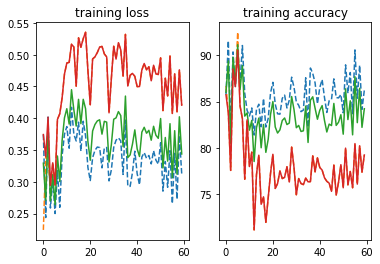

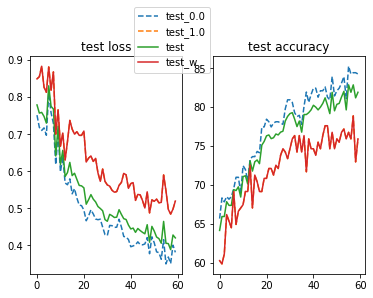

In [15]:
import matplotlib.pyplot as plt
from utils.test_utils import plot_results, load_logs
# save_dir = "../results/simulation/220320_1502"
# loss_gs, acc_gs, loss_log, acc_log = load_logs(save_dir)
plot_results(loss_gs, acc_gs, loss_log, acc_log)

# inspect selection scores for a specific model

In [16]:
from utils.data_utils import make_dataloader
def obtain_sel_loader(total_loader, AL_iter, args):
    st_num = args.init_num + args.AL_batch*AL_iter
    ds = total_loader.dataset.tensors
    sel_loader = make_dataloader(ds[0][st_num:],ds[1][st_num:],ds[2][st_num:],
                                     args.batch_size, False)
    return sel_loader

In [17]:
from utils.data_utils import divide_groupsDL
idx = 35
st = args.problem_type+args.model_type +"_"+ str(idx)+ ".pt"
dataloader = dl_cum_loaders[idx]
selloader = obtain_sel_loader(dl_loader,idx,args)
ds = dataloader.dataset.tensors
grloaders = divide_groupsDL(ds[0],ds[1],ds[2])
clf,clf_criterion = load_test_model(save_dir, st, args)

loaded model is binaryNN_35.pt


/home/srp/research/Fairness/fairness_AL/codes/utils/data_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).clone().detach().float() for da in dataarrays)


In [18]:
import torch
from utils.grad_utils import _is_shuffle
from utils.binary_utils import BinaryEntropy
def compute_indv_entropy(clf, dataloader, device,sel_batch_num):
    assert(_is_shuffle(dataloader)==False)
    
    clf.to(device).eval()
    criterion = BinaryEntropy(reduction='none')
    losses = []
    for dt in dataloader:
        x = dt[0].to(device)
        outs = clf(x)
        loss = criterion(outs)
        losses.append(loss.detach().cpu())
#     print(torch.cat(losses).shape,sel_batch_num)
    max_outs = torch.topk(torch.cat(losses).flatten(),sel_batch_num)
    return max_outs

In [19]:
from utils.grad_utils import compute_mean_grad_dic, compute_indv_grad_dic
from utils.binary_utils import IdentityOutput,BinaryEntropy
EPS =  1e-5
def compute_similarity_with_grad_binary2(clf,val_loader,gr_loader,sel_loader,device,sel_batch_num,
                                        criterion_type = 'identity', param_names=None, 
                                        last_layer=True,sel_idxs=None, normalize=True): 
    # val_loader consists of validation data for a chosen group
    assert(criterion_type in ['identity','binary_entropy'])
    if criterion_type == 'identity':
        ## identity
        criterion = IdentityOutput(reduction ='sum')
    else:
        ## binary_entropy
        criterion = BinaryEntropy(reduction ='sum')
        
    val_wgrad = compute_mean_grad_dic(clf, val_loader,device, criterion,
                                      use_label = False, param_names=param_names, last_layer = last_layer,
                                      sel_idxs=sel_idxs, normalize=False, dictionary=False)
    gr_wgrad = compute_mean_grad_dic(clf, gr_loader,device, criterion,
                                      use_label = False, param_names=param_names, last_layer = last_layer,
                                      sel_idxs=sel_idxs, normalize=False, dictionary=False)
#     print(torch.norm(val_wgrad),torch.norm(gr_wgrad))
#     print(torch.dot(val_wgrad,gr_wgrad))
#     print(val_wgrad,gr_wgrad)
    
    mean_wgrad = torch.sign(gr_wgrad) - torch.sign(val_wgrad)
#     mean_wgrad = torch.sign(gr_wgrad- val_wgrad)
    
    if torch.norm(mean_wgrad) >0:
        if normalize:
            mean_wgrad /= torch.norm(mean_wgrad+EPS)
        
        ind_wgrad = compute_indv_grad_dic(clf, sel_loader, device, criterion, use_label = False, 
                                             param_names=param_names, last_layer = last_layer,
                                             sel_idxs=sel_idxs, dictionary=False)
        print(torch.mean(ind_wgrad,dim=0).norm())
        sim = torch.matmul(ind_wgrad,mean_wgrad)
    #     print(sim.shape)
        max_outs = torch.topk(sim,sel_batch_num)
            
    else:
        ind_wgrad = 0.0
        max_outs = compute_indv_entropy(clf, sel_loader, device,sel_batch_num)
        
    return max_outs,mean_wgrad,ind_wgrad

def compute_similarity_with_grad_binary(clf,val_loader,sel_loader,device,sel_batch_num,
                                        criterion_type = 'identity', param_names=None, 
                                        last_layer=True,sel_idxs=None, normalize=True): 
    # val_loader consists of validation data for a chosen group
    assert(criterion_type in ['identity','binary_entropy'])
    if criterion_type == 'identity':
        ## identity
        criterion = IdentityOutput(reduction ='sum')
    else:
        ## binary_entropy
        criterion = BinaryEntropy(reduction ='sum')
        
    mean_wgrad = compute_mean_grad_dic(clf, val_loader,device, criterion,
                                      use_label = False, param_names=param_names, last_layer = last_layer,
                                      sel_idxs=sel_idxs, normalize=normalize, dictionary=False)
            
    ind_wgrad = compute_indv_grad_dic(clf, sel_loader, device, criterion, use_label = False, 
                                         param_names=param_names, last_layer = last_layer,
                                         sel_idxs=sel_idxs, dictionary=False)

    sim = torch.matmul(torch.sign(ind_wgrad),torch.sign(mean_wgrad))
#     print(sim.shape)
    max_outs = torch.topk(sim,sel_batch_num)
        
    return max_outs,mean_wgrad,ind_wgrad

In [20]:
import matplotlib.pyplot as plt
def plot_select_results(max_outs_list, selloader, list_names = None):
    plot_num = len(max_outs_list)
    if plot_num<2:
        plot_num=2
    if list_names is None:
        list_names = list(range(plot_num))
    fig, axs = plt.subplots(plot_num, 2, figsize=(10,5*plot_num))
    for i, max_outs in enumerate(max_outs_list):
        axs[i, 0].hist(max_outs[0])
        axs[i, 0].set_title(str(list_names[i])+": histogram")
        senz = list(selloader.dataset.tensors[2].numpy())
        senz_rev = torch.tensor([senz[idx.item()] for idx in max_outs[1]]).flatten()
        max0 = max_outs[0][senz_rev==0]
        max1 = max_outs[0][senz_rev==1]
        axs[i, 1].hist(max0,label='group0')
        axs[i, 1].hist(max1,label='group1')
        axs[i, 1].legend()
        axs[i, 1].set_title(str(list_names[i])+": ghistogram")
    fig.show()

## need to split dataloader according to group variable

In [21]:
selnum = len(selloader.dataset.tensors[1])
max_outs = compute_indv_entropy(clf, selloader, device,sel_batch_num=selnum)

In [22]:
import matplotlib.pyplot as plt

In [23]:
selnum = len(selloader.dataset.tensors[1])
max_outs_id,mean_id,ind_id = compute_similarity_with_grad_binary(clf, dataloader, selloader, device,sel_batch_num=selnum,
                                                   criterion_type = 'identity',last_layer=True,normalize=True)
max_outs_id0,mean_id0,ind_id0 = compute_similarity_with_grad_binary2(clf, dataloader, grloaders[0.0], selloader, device,
                                                             sel_batch_num=selnum,
                                                   criterion_type = 'identity',last_layer=True,normalize=False)
max_outs_id1,mean_id1,ind_id1 = compute_similarity_with_grad_binary2(clf, dataloader, grloaders[1.0], selloader, device,
                                                             sel_batch_num=selnum,
                                                   criterion_type = 'identity',last_layer=True,normalize=False)

In [24]:
max_outs_be,mean_be, ind_be = compute_similarity_with_grad_binary(clf, dataloader, selloader, device,sel_batch_num=selnum,
                                                   criterion_type = 'binary_entropy',last_layer=False,normalize=True)
max_outs_be00,mean_be00, ind_be00 = compute_similarity_with_grad_binary(clf, grloaders[0.0], selloader, device,sel_batch_num=selnum,
                                                   criterion_type = 'binary_entropy',last_layer=False,normalize=True)
max_outs_be11,mean_be11, ind_be11 = compute_similarity_with_grad_binary(clf, grloaders[1.0], selloader, device,sel_batch_num=selnum,
                                                   criterion_type = 'binary_entropy',last_layer=False,normalize=True)


In [25]:
max_outs_be,mean_be, ind_be = compute_similarity_with_grad_binary(clf, dataloader, selloader, device,sel_batch_num=selnum,
                                                   criterion_type = 'binary_entropy',last_layer=False,normalize=True)
max_outs_be0,mean_be0,ind_be0 = compute_similarity_with_grad_binary2(clf, dataloader, grloaders[0.0], selloader, device,
                                                             sel_batch_num=selnum,
                                                   criterion_type = 'binary_entropy',last_layer=False,normalize=True)
max_outs_be1,mean_be1,ind_be1 = compute_similarity_with_grad_binary2(clf, dataloader, grloaders[1.0], selloader, device,
                                                             sel_batch_num=selnum,
                                                   criterion_type = 'binary_entropy',last_layer=False,normalize=True)

tensor(45.2116)
tensor(45.2116)


# visualize inputs

In [26]:
from sklearn.decomposition import PCA
xx = selloader.dataset.tensors[0]
xtr = dataloader.dataset.tensors[0]
pca = PCA(n_components=2)
xtr2 = pca.fit_transform(xtr)
xx2 = pca.transform(xx)

In [27]:
print(grloaders[0.0].dataset.tensors[1].shape)
print(grloaders[1.0].dataset.tensors[1].shape)

torch.Size([878, 1])
torch.Size([342, 1])


1 1


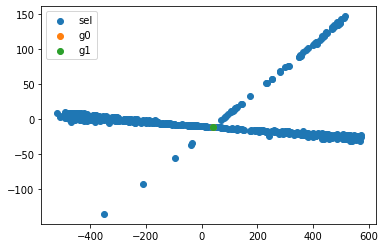

In [28]:
pcaz = PCA(n_components=2)
zz2 = pca.fit_transform(ind_be0)
zz20 = pca.transform(mean_be0.view(1,-1))
zz21 = pca.transform(mean_be1.view(1,-1))
print(len(zz20), len(zz21))
plt.figure()
plt.scatter(zz2[:,0],zz2[:,1],label='sel')
plt.scatter(zz20[:,0],zz20[:,1],label='g0')
plt.scatter(zz21[:,0],zz21[:,1],label='g1')
plt.legend()
plt.show()

In [29]:
# print(mean_be0)
# print(mean_be1)
print(max_outs_be0)
print(max_outs_be1)
print(max_outs)

torch.return_types.topk(
values=tensor([ 6.7165e+00,  6.3777e+00,  6.3743e+00,  6.2825e+00,  6.2133e+00,
         6.2023e+00,  6.1963e+00,  6.0715e+00,  6.0701e+00,  6.0670e+00,
         6.0394e+00,  6.0217e+00,  5.9831e+00,  5.9070e+00,  5.8477e+00,
         5.7951e+00,  5.7816e+00,  5.7722e+00,  5.7127e+00,  5.6947e+00,
         5.6927e+00,  5.6371e+00,  5.6172e+00,  5.5865e+00,  5.5734e+00,
         5.5688e+00,  5.5639e+00,  5.5526e+00,  5.5425e+00,  5.5223e+00,
         5.5195e+00,  5.5143e+00,  5.5143e+00,  5.4871e+00,  5.4642e+00,
         5.4550e+00,  5.4424e+00,  5.4327e+00,  5.4206e+00,  5.4177e+00,
         5.3761e+00,  5.3727e+00,  5.3484e+00,  5.2776e+00,  5.2709e+00,
         5.2513e+00,  5.2417e+00,  5.2345e+00,  5.2343e+00,  5.1952e+00,
         5.1913e+00,  5.1727e+00,  5.1426e+00,  5.1223e+00,  5.1029e+00,
         5.0775e+00,  5.0767e+00,  5.0695e+00,  5.0629e+00,  5.0443e+00,
         5.0431e+00,  5.0116e+00,  5.0109e+00,  4.9383e+00,  4.9049e+00,
         4.8511e+00

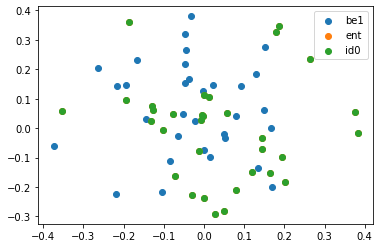

In [30]:
plt.figure()
# plt.scatter(xtr2[:,0],xtr2[:,1])
plt.scatter(xx2[max_outs_be1[1][:32],0], xx2[max_outs_be1[1][:32],1],label="be1")
plt.scatter(xx2[max_outs[1][:32],0], xx2[max_outs[1][:32],1],label="ent")
plt.scatter(xx2[max_outs_id1[1][:32],0], xx2[max_outs_id1[1][:32],1],label="id0")
plt.legend()
plt.show()

In [31]:
xx = selloader.dataset.tensors[0]
print(max_outs[1][:32])
print(max_outs_be1[1][:32])
print(max_outs_be11[1][:32])

tensor([661, 390, 387, 577, 355, 513,   7, 581, 351, 274,   3, 122, 223, 184,
        691, 128, 517, 533, 270,  21, 462, 267, 660, 177, 448, 327, 260, 592,
        537, 418, 303,  44])
tensor([227, 330, 575,  67, 292, 593,  51, 479, 121, 582, 247, 663, 388, 357,
        699, 153, 442, 531,  29, 392, 311, 286,  89,  17, 332, 356, 551, 561,
        350, 569, 658, 211])
tensor([256, 389, 637, 686, 677, 398, 480, 159, 720, 104, 497, 294, 186, 630,
        157, 158, 498, 430, 101, 676, 449, 708, 231, 692, 218, 251, 103, 321,
        358, 359, 327, 326])


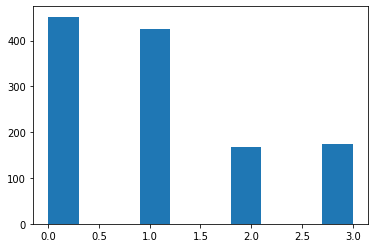

In [32]:
# print(dataloader.dataset.tensors[2].flatten())
plt.hist(dataloader.dataset.tensors[2].flatten()*2+dataloader.dataset.tensors[1].flatten())
plt.show()

===== original total select loader =====


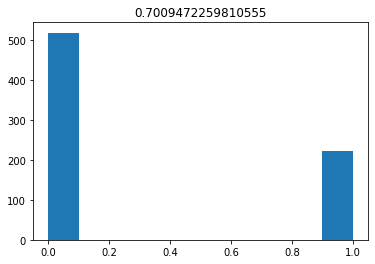

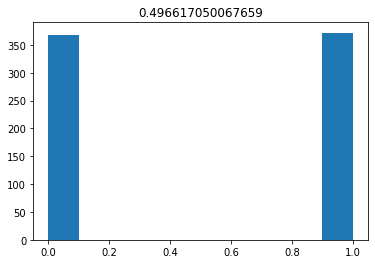

In [33]:
truez = selloader.dataset.tensors[2].flatten()
truey = selloader.dataset.tensors[1].flatten()

print("="*5,"original total select loader", "="*5)
plt.hist(truez)
plt.title(str(sum(np.array(truez)==0)/len(truez)))
plt.show()
plt.hist(truey)
plt.title(str(sum(np.array(truey)==0)/len(truey)))
plt.show()

In [34]:
datanum = 100

===== binary entropy for whole group gradient =====


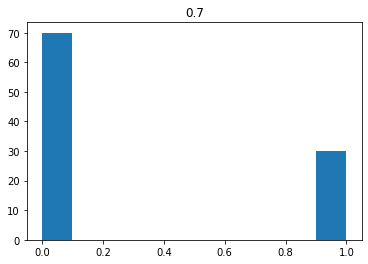

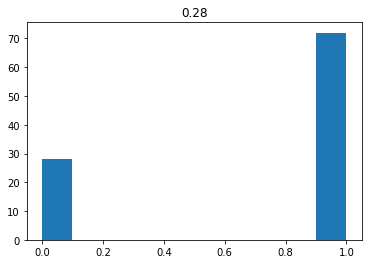

In [35]:
print("="*5,"binary entropy for whole group gradient", "="*5)
truez = [selloader.dataset.tensors[2][z.item()] for z in max_outs_be[1][:datanum]]
truey = [selloader.dataset.tensors[1][z.item()] for z in max_outs_be[1][:datanum]]
plt.hist(truez)
plt.title(str(sum(np.array(truez)==0)/len(truez)))
plt.show()
plt.hist(truey)
plt.title(str(sum(np.array(truey)==0)/len(truey)))
plt.show()

===== binary entropy for group 0 gradient =====


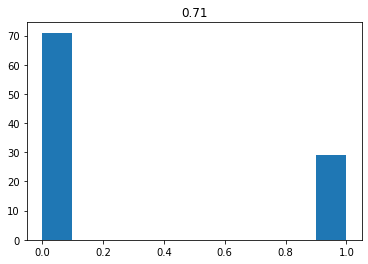

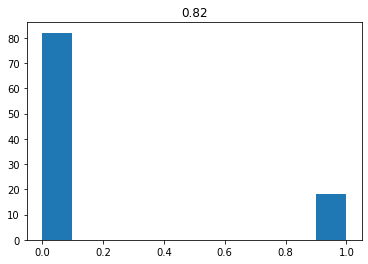

In [36]:
print("="*5,"binary entropy for group 0 gradient", "="*5)
truez = [selloader.dataset.tensors[2][z.item()] for z in max_outs_be0[1][:datanum]]
truey = [selloader.dataset.tensors[1][z.item()] for z in max_outs_be0[1][:datanum]]
plt.hist(truez)
plt.title(str(sum(np.array(truez)==0)/len(truez)))
plt.show()
plt.hist(truey)
plt.title(str(sum(np.array(truey)==0)/len(truey)))
plt.show()


===== binary entropy for group 1 gradient =====


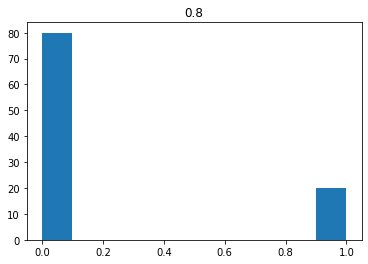

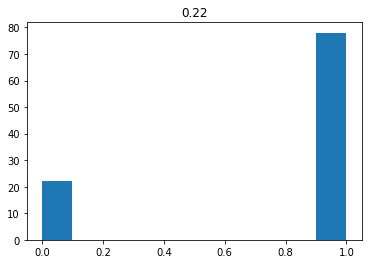

In [37]:
print("="*5,"binary entropy for group 1 gradient", "="*5)
truez = [selloader.dataset.tensors[2][z.item()] for z in max_outs_be1[1][:datanum]]
truey = [selloader.dataset.tensors[1][z.item()] for z in max_outs_be1[1][:datanum]]
plt.hist(truez)
plt.title(str(sum(np.array(truez)==0)/len(truez)))
plt.show()
plt.hist(truey)
plt.title(str(sum(np.array(truey)==0)/len(truey)))
plt.show()

In [38]:
print(max_outs_be1)
print(max_outs)

torch.return_types.topk(
values=tensor([ 2.1344e+01,  2.1012e+01,  2.0232e+01,  1.9417e+01,  1.8962e+01,
         1.8847e+01,  1.8705e+01,  1.8697e+01,  1.8661e+01,  1.8658e+01,
         1.8592e+01,  1.8492e+01,  1.8392e+01,  1.8323e+01,  1.8279e+01,
         1.8224e+01,  1.8174e+01,  1.8134e+01,  1.8072e+01,  1.7883e+01,
         1.7712e+01,  1.7676e+01,  1.7673e+01,  1.7664e+01,  1.7573e+01,
         1.7558e+01,  1.7486e+01,  1.7461e+01,  1.7453e+01,  1.7414e+01,
         1.7333e+01,  1.7318e+01,  1.7233e+01,  1.7200e+01,  1.7101e+01,
         1.7042e+01,  1.6985e+01,  1.6974e+01,  1.6967e+01,  1.6929e+01,
         1.6860e+01,  1.6853e+01,  1.6718e+01,  1.6704e+01,  1.6694e+01,
         1.6635e+01,  1.6632e+01,  1.6628e+01,  1.6586e+01,  1.6549e+01,
         1.6389e+01,  1.6380e+01,  1.6252e+01,  1.6242e+01,  1.6032e+01,
         1.6028e+01,  1.5923e+01,  1.5892e+01,  1.5854e+01,  1.5842e+01,
         1.5822e+01,  1.5812e+01,  1.5711e+01,  1.5690e+01,  1.5679e+01,
         1.5640e+01

===== entropy for all =====


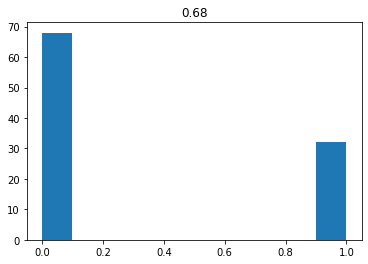

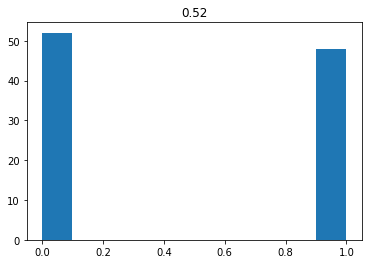

In [39]:
print("="*5,"entropy for all", "="*5)
truez = [selloader.dataset.tensors[2][z.item()] for z in max_outs[1][:datanum]]
truey = [selloader.dataset.tensors[1][z.item()] for z in max_outs[1][:datanum]]
plt.hist(truez)
plt.title(str(sum(np.array(truez)==0)/len(truez)))
plt.show()
plt.hist(truey)
plt.title(str(sum(np.array(truey)==0)/len(truey)))
plt.show()

In [40]:
torch.dot(mean_be0, mean_be1)

tensor(0.)

In [41]:
9305.4355/(129.2098*72.3006)

0.9960917601512013

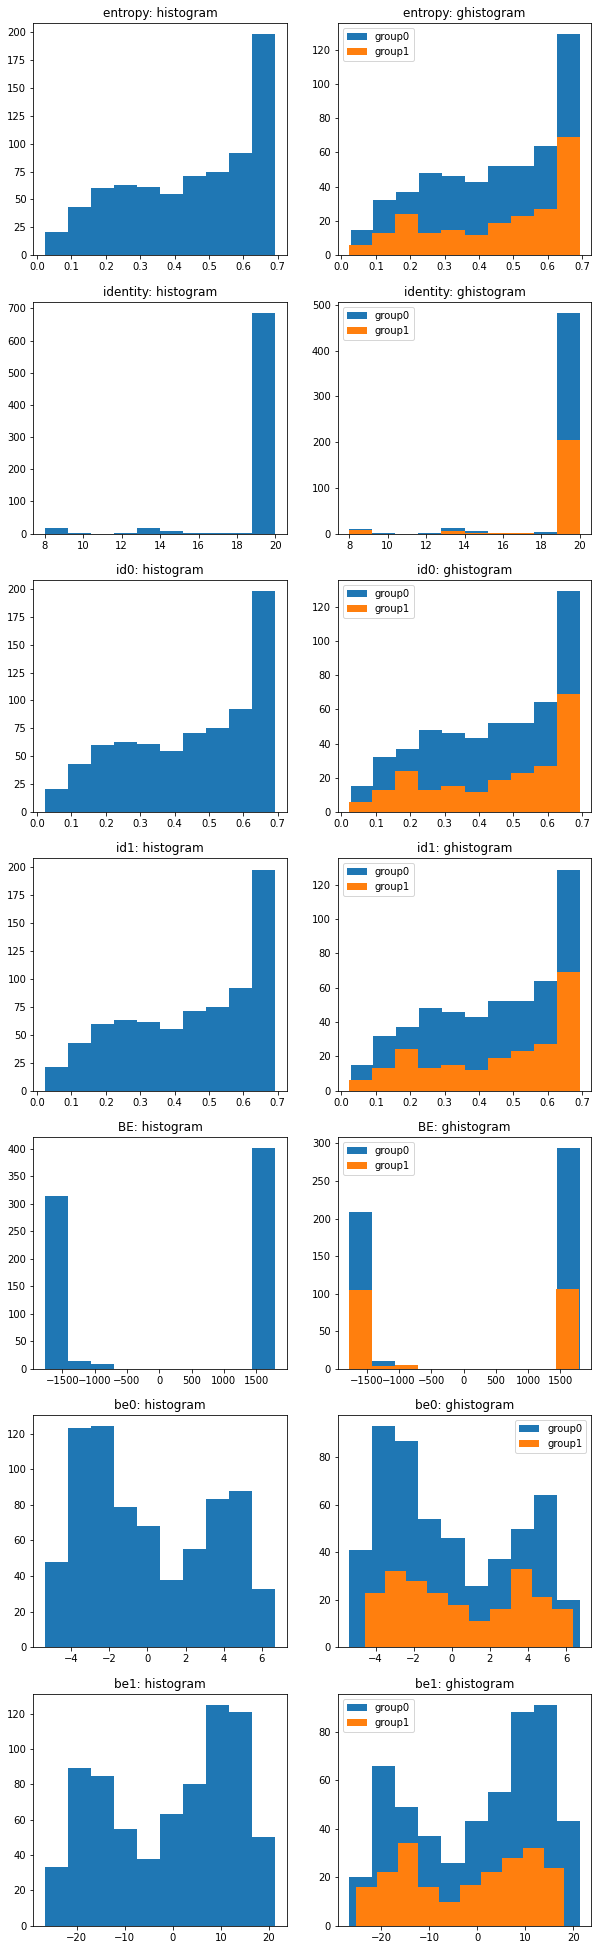

In [42]:
outs_name = ["entropy","identity","id0","id1","BE","be0","be1"]
outs_list = [max_outs,max_outs_id,max_outs_id0,max_outs_id1, max_outs_be, max_outs_be0, max_outs_be1]
plot_select_results(outs_list, selloader,outs_name)

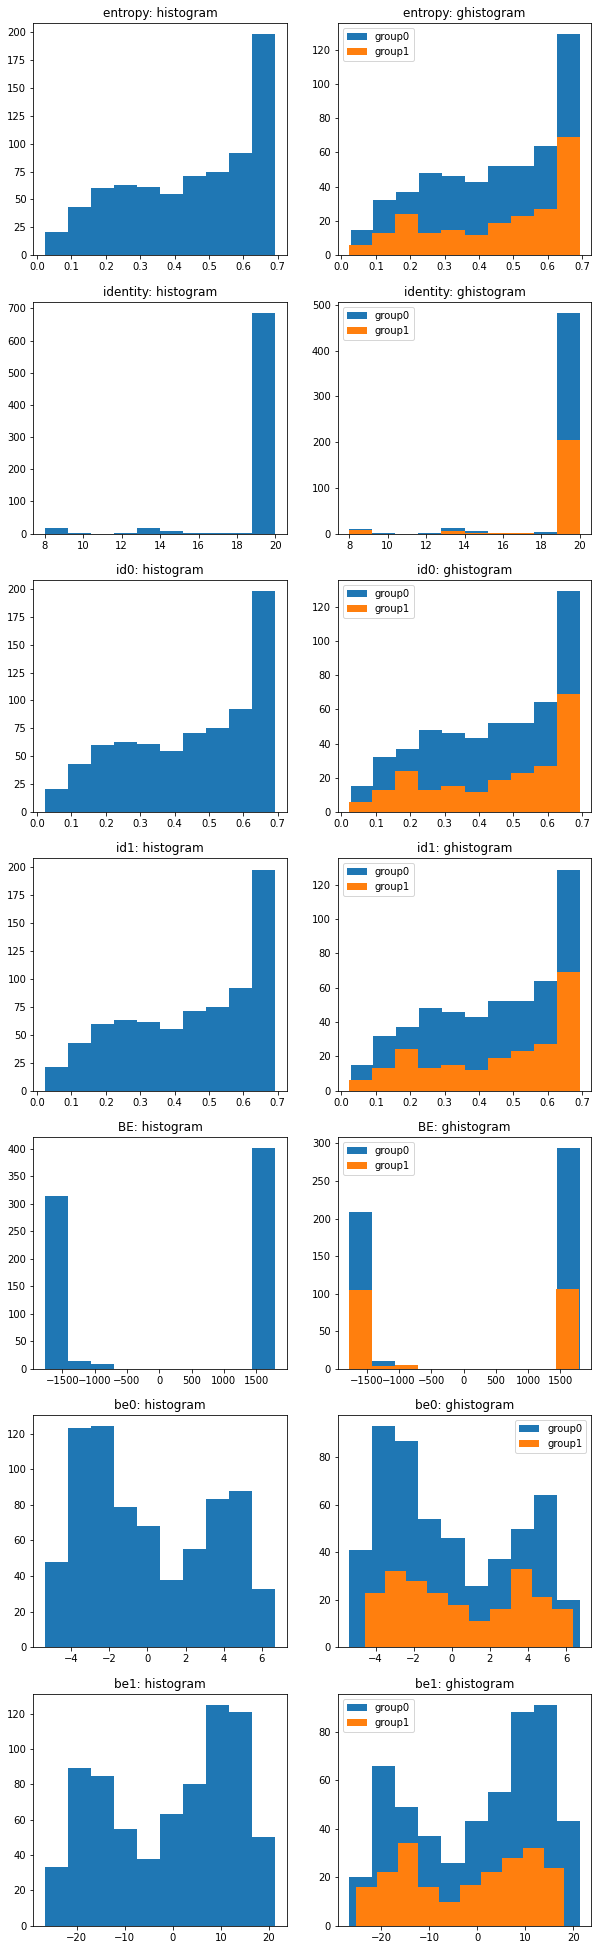

In [43]:
outs_name = ["entropy","identity","id0","id1","BE","be0","be1"]
outs_list = [max_outs,max_outs_id,max_outs_id0,max_outs_id1, max_outs_be, max_outs_be0, max_outs_be1]
plot_select_results(outs_list, selloader,outs_name)

In [44]:
from sklearn.metrics import f1_score, roc_auc_score
from utils.eval_utils import accuracy_b

def predict_model(model, test_loader, device,as_np = False):
    model.to(device).eval()
    preds = []
    ys = []
    zs = []
    with torch.no_grad():
        for batch_idx, ts in enumerate(test_loader):
            ys.append(ts[1])
            if len(ts)>2:
                zs.append(ts[2])
            preds.append(model(ts[0].to(device)).detach().cpu())
            del ts
    preds = torch.cat(preds,0)
    ys = torch.cat(ys,0)
    if len(zs)>0:
        zs = torch.cat(zs,0)
    else:
        zs = torch.tensor(zs)
    if as_np:
        return preds.numpy(), ys.numpy(), zs.numpy()
    else:
        return preds, ys, zs
def binary_scores(output, target, prob=True, thres = 0.5):
    score_dic = {}
    if prob:
        pred = torch.tensor(output>thres, dtype=torch.float32)
    else:
        pred = output
    score_dic['weighted'] = f1_score(target, pred, average='weighted')*100
    score_dic['macro'] = f1_score(target, pred, average='macro')*100
    score_dic['micro'] = f1_score(target, pred, average='micro')*100
    score_dic['accuracy'] = accuracy_b(pred, target).item()
    score_dic['roc_auc'] = roc_auc_score(target,output)*100
    
    print('weighted: ', score_dic['weighted'])
    print('macro: ',score_dic['macro'])
    print('micro: ',score_dic['micro'])            
    print('accuracy: ', score_dic['accuracy'])      
    if prob:
        print("roc auc: ", score_dic['roc_auc'])
    return score_dic
    
    
def test_binary_model(model, test_loader, device):
    preds, ys, zs = predict_model(model, test_loader, device)
    res = []
    print("="*30)
    print("binary scores for all data")
    print("="*30)
    res.append(binary_scores(preds,ys, prob=True, thres = 0.5))
    if len(zs)>0:
        zu = torch.unique(zs)
        for zi in zu:
            print("="*30)
            print("binary score for group: ",zi.item())
            print("="*30)
            zidx = zs ==zi
            res.append(binary_scores(preds[zidx].view(-1,1),ys[zidx].view(-1,1), 
                          prob=True, thres = 0.5))
    return res

In [45]:
test_binary_model(clf, test_loader, device)

binary scores for all data
weighted:  76.81331747919144
macro:  76.81331747919144
micro:  76.81331747919144
accuracy:  76.81331634521484
roc auc:  84.77124183006536
binary score for group:  0.0
weighted:  77.79778358651446
macro:  77.81238006469653
micro:  77.81456953642383
accuracy:  77.81456756591797
roc auc:  86.54684815646888
binary score for group:  1.0
weighted:  74.29736834331302
macro:  74.24509646731869
micro:  74.26160337552744
accuracy:  74.26160430908203
roc auc:  80.36840596330276


<ipython-input-44-e7d3730bcace>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thres, dtype=torch.float32)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thr,dtype = torch.float32)
<ipython-input-44-e7d3730bcace>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(output>thres, dtype=torch.float32)
/home/srp/research/Fairness/fairness_AL/codes/utils/eval_utils.py:176: UserWarning: To copy constru

[{'weighted': 76.81331747919144,
  'macro': 76.81331747919144,
  'micro': 76.81331747919144,
  'accuracy': 76.81331634521484,
  'roc_auc': 84.77124183006536},
 {'weighted': 77.79778358651446,
  'macro': 77.81238006469653,
  'micro': 77.81456953642383,
  'accuracy': 77.81456756591797,
  'roc_auc': 86.54684815646888},
 {'weighted': 74.29736834331302,
  'macro': 74.24509646731869,
  'micro': 74.26160337552744,
  'accuracy': 74.26160430908203,
  'roc_auc': 80.36840596330276}]

In [46]:
pred_y = torch.tensor(preds>0.5, dtype = torch.float32)

NameError: name 'preds' is not defined

In [ ]:
from sklearn.metrics import f1_score,roc_auc_score

print(f1_score(ys, pred_y,average='weighted'))
print(f1_score(ys, pred_y,average='macro'))
print(f1_score(ys, pred_y,average='micro'))
print(roc_auc_score(ys, preds))

# save result logs

In [ ]:
from utils.test_utils import save_logs, load_logs

In [ ]:
# save_logs(save_dir, loss_gs, acc_gs, loss_log, acc_log)

# Load logs

In [ ]:
# loss_gs, acc_gs, loss_log, acc_log = load_logs(save_dir)

In [ ]:
dl_cum_loaders[it].dataset.tensors[1].numpy().shape

In [ ]:
import numpy as np
np.unique(dl_cum_loaders[it].dataset.tensors[0].numpy(),axis=0).shape

In [ ]:
from utils.data_utils import dataset_description, dl2nparray

In [ ]:
for i in range(len(dl_loaders)):
    print("data loader",i)
    if i>0:
        print("selected group is", gids[i-1])
    x,y,z = dl2nparray(dl_loaders[i])
    dataset_description(x,y,z)

In [ ]:
for i in range(len(dl_loaders)):
    print("data cumulative loader",i)
    x,y,z = dl2nparray(dl_cum_loaders[i])
    dataset_description(x,y,z)

In [ ]:
x,y,z = dl2nparray(test_loader)
dataset_description(x,y,z)

In [ ]:
dl_loader.dataset.tensors[0].shape

In [56]:
all_acc = [0.75566667, 0.76722222, 0.77466667, 0.77977778, 0.78755556, 0.79011111,
 0.79577778, 0.806,      0.80944444, 0.81688889, 0.81366667, 0.81488889,
 0.81877778, 0.82222222, 0.82355556, 0.82644444, 0.831,      0.83077778,
 0.83188889, 0.83488889, 0.83744444, 0.83966667, 0.84344444, 0.84477778,
 0.84677778, 0.84811111, 0.848,      0.84933333, 0.85055556, 0.85277778,
 0.85344444, 0.85477778, 0.85488889, 0.85466667, 0.85622222, 0.85711111,
 0.85866667, 0.85788889, 0.85822222, 0.85966667, 0.86011111, 0.85977778,
 0.85988889, 0.86066667, 0.86033333, 0.86177778, 0.86311111, 0.86366667,
 0.86411111, 0.86433333]
g0_acc = [0.77135783, 0.78437482, 0.78984104, 0.79531273, 0.80621143, 0.80891167,
 0.81410646, 0.82522084, 0.8325519,  0.84001331, 0.83800748, 0.83881225,
 0.84165849, 0.84611088, 0.84898955, 0.8516169,  0.85518775, 0.8547969,
 0.85494712, 0.85691775, 0.85857554, 0.86021653, 0.86572802, 0.8693151,
 0.86948487, 0.8710667, 0.87265362, 0.87324681, 0.87525863, 0.87727422,
 0.87852759, 0.87855987, 0.8790869,  0.87795619, 0.88171829, 0.88160499,
 0.88428235, 0.88346264, 0.88461992, 0.88593628, 0.88682345, 0.88664032,
 0.88643486, 0.88684121, 0.88746477, 0.88848734, 0.8891692,  0.89000469,
 0.88986754, 0.89040337]
g1_acc = [0.72355469, 0.73305028, 0.74425323, 0.74892322, 0.75039487, 0.75297968,
 0.75927363, 0.76795712, 0.76353601, 0.77125807, 0.76565339, 0.76756775,
 0.77376304, 0.77489073, 0.77317274, 0.77654372, 0.78319812, 0.78311853,
 0.78604878, 0.79117314, 0.79554044, 0.79885397, 0.79938937, 0.79607359,
 0.8018151,  0.80278036, 0.79910147, 0.80202763, 0.80179627, 0.80438192,
 0.80356491, 0.80761856, 0.8068824,  0.80854015, 0.80563596, 0.80870681,
 0.80792594, 0.80720564, 0.80596873, 0.80759637, 0.80741074, 0.80668419,
 0.80728143, 0.8090055,  0.80666541, 0.80910232, 0.81167961, 0.81168477,
 0.81351565, 0.81304232]

In [57]:
all_acc_rs = [0.75566667,0.76722222,0.77466667,0.77977778,0.78755556,0.79011111,0.79577778,0.806,0.80944444,0.81688889,0.81366667,0.81488889,0.81877778,0.82222222,0.82355556,0.82644444,0.831,0.83077778,0.83188889,0.83488889,0.83744444,0.83966667,0.84344444,0.84477778,0.84677778,0.84811111,0.848,0.84933333,0.85055556,0.85277778,0.85344444,0.85477778,0.85488889,0.85466667,0.85622222,0.85711111,0.85866667,0.85788889,0.85822222,0.85966667,0.86011111,0.85977778,0.85988889,0.86066667,0.86033333,0.86177778,0.86311111,0.86366667,0.86411111,0.86433333]
g0_acc_rs = [0.77135783,0.78437482,0.78984104,0.79531273,0.80621143,0.80891167,0.81410646,0.82522084,0.8325519,0.84001331,0.83800748,0.83881225,0.84165849,0.84611088,0.84898955,0.8516169,0.85518775,0.8547969,0.85494712,0.85691775,0.85857554,0.86021653,0.86572802,0.8693151,0.86948487,0.8710667,0.87265362,0.87324681,0.87525863,0.87727422,0.87852759,0.87855987,0.8790869,0.87795619,0.88171829,0.88160499,0.88428235,0.88346264,0.88461992,0.88593628,0.88682345,0.88664032,0.88643486,0.88684121,0.88746477,0.88848734,0.8891692,0.89000469,0.88986754,0.89040337]
g1_acc_rs = [0.72355469,0.73305028,0.74425323,0.74892322,0.75039487,0.75297968,0.75927363,0.76795712,0.76353601,0.77125807,0.76565339,0.76756775,0.77376304,0.77489073,0.77317274,0.77654372,0.78319812,0.78311853,0.78604878,0.79117314,0.79554044,0.79885397,0.79938937,0.79607359,0.8018151,0.80278036,0.79910147,0.80202763,0.80179627,0.80438192,0.80356491,0.80761856,0.8068824,0.80854015,0.80563596,0.80870681,0.80792594,0.80720564,0.80596873,0.80759637,0.80741074,0.80668419,0.80728143,0.8090055,0.80666541,0.80910232,0.81167961,0.81168477,0.81351565,0.81304232]

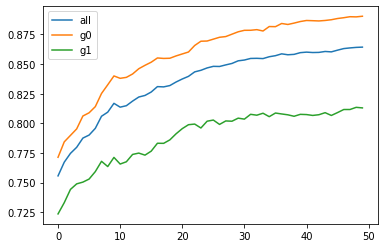

In [58]:
plt.figure()
plt.plot(all_acc, '-',label='all')
plt.plot(g0_acc, '-',label='g0')
plt.plot(g1_acc, '-',label='g1')
plt.legend()
plt.show()

In [59]:
all_acc_us = [0.75566667,0.77855556,0.78688889,0.79555556,0.80144444,0.80888889,0.82011111,0.82411111,0.833,0.83833333,0.839,0.842,0.84911111,0.85122222,0.85266667,0.85533333,0.861,0.85922222,0.86166667,0.86255556,0.86666667,0.86455556,0.86777778,0.86911111,0.87022222,0.86822222,0.86633333,0.87055556,0.869,0.87277778,0.87111111,0.87155556,0.87411111,0.87422222,0.87433333,0.87322222,0.873,0.87422222,0.87377778,0.87488889,0.87477778,0.87366667,0.87288889,0.87244444,0.87411111,0.87266667,0.873,0.87466667,0.87322222,0.87411111]
g0_acc_us = [0.77135783,0.79232917,0.8045743,0.81515017,0.82133451,0.83107213,0.84547699,0.85123612,0.8639673,0.86962077,0.87244007,0.87785794,0.88220908,0.88233308,0.88607192,0.8909066,0.89645433,0.89565418,0.90025109,0.90022005,0.905322,0.90120214,0.90447016,0.90916511,0.90868526,0.90644912,0.90743099,0.9127946,0.90832645,0.91193772,0.90975131,0.91178506,0.91294785,0.91146214,0.9124857,0.91084084,0.91101661,0.91188025,0.90997869,0.91001666,0.91055731,0.90837789,0.90721098,0.90651274,0.90790005,0.90722506,0.90727218,0.90775354,0.90605527,0.90736732]
g1_acc_us = [0.72355469,0.75064129,0.75129558,0.75643016,0.76180867,0.7646963,0.76969386,0.77073951,0.77171044,0.77628434,0.77250991,0.77091409,0.7838604,0.78969206,0.78683055,0.78489658,0.79072676,0.78734122,0.78535095,0.7879029,0.790329,0.79229371,0.79541343,0.79020929,0.79455261,0.79271845,0.78520405,0.78724483,0.79122754,0.79567944,0.79479328,0.79224083,0.79758263,0.80088443,0.79931262,0.79917795,0.79843472,0.80023601,0.80261916,0.80589312,0.80457339,0.80537821,0.80548567,0.80557049,0.80786932,0.80486854,0.80591483,0.80986711,0.80887487,0.80887718]

In [60]:
all_acc_gbe = [0.75566667,0.76033333,0.76122222,0.76522222,0.77088889,0.77,0.77255556,0.77011111,0.77577778,0.77622222,0.77911111,0.77888889,0.78222222,0.78155556,0.78244444,0.78544444,0.78311111,0.78766667,0.786,0.788,0.78555556,0.78555556,0.78422222,0.788,0.79055556,0.79066667,0.78922222,0.79066667,0.79511111,0.79422222,0.79411111,0.79566667,0.79911111,0.79888889,0.79944444,0.79977778,0.79977778,0.80455556,0.80666667,0.81077778,0.81211111,0.81344444,0.81977778,0.81844444,0.82055556,0.82522222,0.82644444,0.82855556,0.83133333,0.83344444]
g0_acc_gbe = [0.77135783,0.77494505,0.77416674,0.77764057,0.78446408,0.78552971,0.78777574,0.78314689,0.78720094,0.78816225,0.79305198,0.79554928,0.79738359,0.79536723,0.79669732,0.80106507,0.79888635,0.80211414,0.80079732,0.80138258,0.7979669,0.79985476,0.79712878,0.80155358,0.80305499,0.80424265,0.80326887,0.80459648,0.80918547,0.80780983,0.80746825,0.80864267,0.81027605,0.80996556,0.81040434,0.81218445,0.81192845,0.81791252,0.82145958,0.82590961,0.82970126,0.83055745,0.83751361,0.83822383,0.84070497,0.84586807,0.84621765,0.84810223,0.85170083,0.85317593]
g1_acc_gbe = [0.72355469,0.73095801,0.73533135,0.74049779,0.74383863,0.73931462,0.74273318,0.74470555,0.75363706,0.75287441,0.75134963,0.74589539,0.7518996,0.75393321,0.75382604,0.75419676,0.75170204,0.7590416,0.75662171,0.76109738,0.76053766,0.7570277,0.758133,0.76063551,0.76539167,0.76358141,0.7612069,0.76298985,0.76736995,0.76737591,0.76753182,0.76998181,0.77691256,0.77709874,0.77792355,0.77512384,0.77587973,0.77808938,0.77750714,0.78060062,0.77723041,0.77961229,0.78454749,0.77920239,0.78078647,0.78434227,0.78731296,0.79001721,0.79100282,0.79433737]

In [61]:
all_acc_gpr = [0.75566667,0.765,0.77011111,0.77177778,0.77944444,0.77844444,0.77911111,0.77855556,0.78422222,0.788,0.78988889,0.79366667,0.79655556,0.79888889,0.80222222,0.80755556,0.81211111,0.81333333,0.816,0.81788889,0.81966667,0.819,0.82022222,0.82322222,0.82577778,0.82655556,0.83088889,0.832,0.83344444,0.83633333,0.83966667,0.83822222,0.84133333,0.84088889,0.84266667,0.84355556,0.84611111,0.84155556,0.84233333,0.84677778,0.84788889,0.849,0.85044444,0.85166667,0.85222222,0.85588889,0.85511111,0.856,0.85644444,0.859]
g0_acc_gpr = [0.77135783,0.78086766,0.7857089,0.78479948,0.79439534,0.79438154,0.796156,0.79658935,0.80308596,0.80711998,0.80800638,0.81285579,0.81574851,0.81990863,0.82457883,0.82892221,0.83212143,0.83124235,0.83662347,0.83825463,0.83878276,0.83651323,0.83689771,0.83902667,0.84206185,0.84226993,0.84864977,0.84982515,0.85264056,0.85589674,0.8583788,0.8569644,0.86212521,0.86012065,0.86220671,0.86298821,0.86500227,0.85982224,0.86220974,0.86791235,0.8687253,0.86821499,0.86987129,0.87153034,0.87203396,0.87718741,0.87685425,0.87724942,0.87773594,0.88086883]
g1_acc_gpr = [0.72355469,0.73301914,0.73833184,0.74557234,0.749868,0.74664053,0.74565321,0.74311847,0.74677786,0.75032102,0.75432737,0.75590936,0.75875622,0.75783552,0.75823261,0.76554156,0.77304777,0.7786166,0.77564447,0.77838088,0.78281041,0.7852975,0.78813453,0.79290765,0.79439942,0.79587235,0.79610229,0.79710005,0.79575062,0.79817736,0.80318746,0.80154281,0.80059328,0.80318259,0.80454905,0.80535255,0.80904741,0.80569559,0.8032721,0.80517569,0.80704846,0.81138586,0.81241023,0.812824,0.81341224,0.81401641,0.81264275,0.81461507,0.81492037,0.81622449]

In [74]:
with open('fairAL_nested.res','rb') as f:
    res_nest = pickle.load(f)
all_acc_nes = np.mean(res_nest['acc_te'],axis=0)
g0_acc_nes = np.mean(res_nest['acc_te0'],axis=0)
g1_acc_nes = np.mean(res_nest['acc_te1'],axis=0)

In [75]:
all_acc_nes

array([0.75566667, 0.772     , 0.78566667, 0.79111111, 0.79988889,
       0.80344444, 0.81033333, 0.815     , 0.82211111, 0.82422222,
       0.83622222, 0.83977778, 0.84555556, 0.849     , 0.85266667,
       0.85411111, 0.858     , 0.86      , 0.861     , 0.85933333,
       0.85966667, 0.86377778, 0.86766667, 0.86755556, 0.87122222,
       0.86977778, 0.86944444, 0.87033333, 0.86933333, 0.87088889,
       0.87444444, 0.871     , 0.87088889, 0.87277778, 0.87388889,
       0.87411111, 0.87588889, 0.87555556, 0.87466667, 0.87688889,
       0.876     , 0.87511111, 0.87544444, 0.876     , 0.87611111,
       0.87633333, 0.87644444, 0.87511111, 0.87544444, 0.87455556])

In [83]:
print(all_acc_nes)
print(g0_acc_nes)
print(g1_acc_nes)

[0.75566667 0.772      0.78566667 0.79111111 0.79988889 0.80344444
 0.81033333 0.815      0.82211111 0.82422222 0.83622222 0.83977778
 0.84555556 0.849      0.85266667 0.85411111 0.858      0.86
 0.861      0.85933333 0.85966667 0.86377778 0.86766667 0.86755556
 0.87122222 0.86977778 0.86944444 0.87033333 0.86933333 0.87088889
 0.87444444 0.871      0.87088889 0.87277778 0.87388889 0.87411111
 0.87588889 0.87555556 0.87466667 0.87688889 0.876      0.87511111
 0.87544444 0.876      0.87611111 0.87633333 0.87644444 0.87511111
 0.87544444 0.87455556]
[0.77135783 0.78964449 0.80184818 0.80764799 0.81747623 0.82408861
 0.83126134 0.83704772 0.84614838 0.84752286 0.85936112 0.86380542
 0.86821776 0.87505111 0.88107784 0.88351613 0.88884204 0.89020942
 0.8923484  0.89202411 0.89325805 0.89852931 0.9020635  0.90290134
 0.90523288 0.90680432 0.90590718 0.9073657  0.90618019 0.90881263
 0.91250521 0.90934679 0.90917992 0.91179532 0.9114553  0.90967332
 0.91184905 0.91170002 0.91036987 0.91157788

In [76]:
with open('fairAL_alpha_agg.res','rb') as f:
    res_agg = pickle.load(f)
all_acc_agg = np.mean(res_agg['acc_te'],axis=0)
g0_acc_agg = np.mean(res_agg['acc_te0'],axis=0)
g1_acc_agg = np.mean(res_agg['acc_te1'],axis=0)

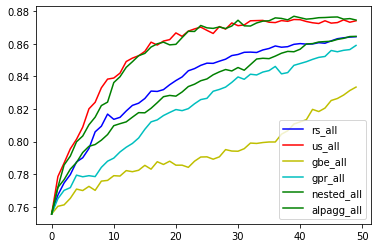

In [77]:
plt.figure()
plt.plot(all_acc_rs, label='rs_all', c = 'b')
plt.plot(all_acc_us, label='us_all', c = 'r')
plt.plot(all_acc_gbe, label='gbe_all', c = 'y')
plt.plot(all_acc_gpr, label='gpr_all', c = 'c')
plt.plot(all_acc_nes, label='nested_all', c = 'g')
plt.plot(all_acc_agg, label='alpagg_all', c = 'violet')
plt.legend()
plt.show()

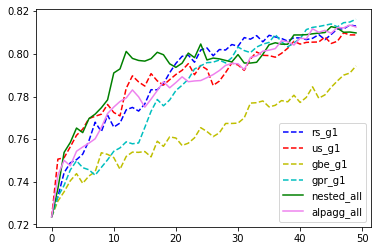

In [78]:
plt.figure()
plt.plot(g1_acc_rs, '--', label='rs_g1', c = 'b')
plt.plot(g1_acc_us, '--', label='us_g1', c = 'r')
plt.plot(g1_acc_gbe, '--', label='gbe_g1', c = 'y')
plt.plot(g1_acc_gpr, '--', label='gpr_g1', c = 'c')
plt.plot(g1_acc_nes, label='nested_all', c = 'g')
plt.plot(g1_acc_agg, label='alpagg_all', c = 'violet')
plt.legend()
plt.show()

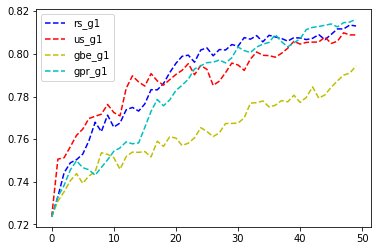

In [67]:
plt.figure()
# plt.plot(all_acc_rs, label='rs_all', c = 'b')
# plt.plot(all_acc_us, label='us_all', c = 'r')
# plt.plot(all_acc_gbe, label='gbe_all', c = 'y')
# plt.plot(all_acc_gpr, label='gpr_all', c = 'c')
# plt.plot(g0_acc_rs, ':', label='rs_g0', c = 'b')
# plt.plot(g0_acc_us, ':', label='us_g0', c = 'r')
# plt.plot(g0_acc_gbe, ':', label='gbe_g0', c = 'y')
# plt.plot(g0_acc_gpr, ':', label='gpr_g0', c = 'c')
plt.plot(g1_acc_rs, '--', label='rs_g1', c = 'b')
plt.plot(g1_acc_us, '--', label='us_g1', c = 'r')
plt.plot(g1_acc_gbe, '--', label='gbe_g1', c = 'y')
plt.plot(g1_acc_gpr, '--', label='gpr_g1', c = 'c')
plt.legend()
plt.show()

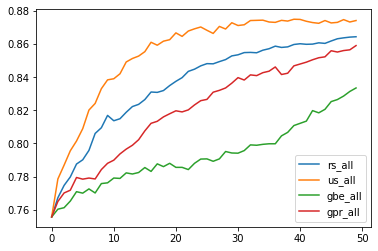

In [65]:
plt.figure()
plt.plot(all_acc_rs, label='rs_all')
plt.plot(all_acc_us, label='us_all')
plt.plot(all_acc_gbe, label='gbe_all')
plt.plot(all_acc_gpr, label='gpr_all')
plt.legend()
plt.show()

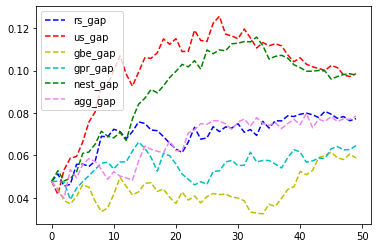

In [80]:
import numpy as np
plt.figure()
plt.plot(np.array(g0_acc_rs)-np.array(g1_acc_rs), '--', label='rs_gap', c = 'b')
plt.plot(np.array(g0_acc_us)-np.array(g1_acc_us), '--', label='us_gap', c = 'r')
plt.plot(np.array(g0_acc_gbe)-np.array(g1_acc_gbe), '--', label='gbe_gap', c = 'y')
plt.plot(np.array(g0_acc_gpr)-np.array(g1_acc_gpr), '--', label='gpr_gap', c = 'c')
plt.plot(np.array(g0_acc_nes)-np.array(g1_acc_nes), '--', label='nest_gap', c = 'g')
plt.plot(np.array(g0_acc_agg)-np.array(g1_acc_agg), '--', label='agg_gap', c = 'violet')
plt.legend()
plt.show()